In [1]:

import os,sys,glob
# Move two levels up work from project level, not location of analysis file
os.chdir('../..')
print(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import Functions.globalFunctions.ExtracellularField as EcF
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from typing import Literal
from scipy import integrate
import ipympl
import time
import seaborn as sns
from scipy import stats
from scipy import optimize
#import warnings
from Analyses.SDC_singlePulse_fixedIntensity.tools import *
from Analyses.SDC_singlePulse_fixedIntensity import loader

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
#warnings.filterwarnings('error',category=UserWarning)

%matplotlib inline
recollect = False


d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code


In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if not cbar_kw is False:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def linearReg(dataframe,features,axs,filteronthreshold,xdata_str='Gmax_log10',plot_flag = True,scatterplot=True):
    ress = []
    tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
    for feat,ax in zip(features,axs):
        xdata = np.array(dataframe[xdata_str])
        ydata = np.array(dataframe[feat])
        idx = ~np.isnan(ydata)
        if filteronthreshold:
            idx = ~np.isnan(np.array(dataframe['amp_log10'])) & idx
        xdata = xdata[idx]
        xvals = np.unique(xdata)
        ydata = ydata[idx]
        res = stats.linregress(xdata, ydata)
        ts = tinv(0.05, len(xdata)-2)
        print(f"\n{feat}\nRsquared: {res.rvalue**2}\nslope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
        print(f"intercept (95%): {res.intercept:.6f} +/- {ts*res.intercept_stderr:.6f}")


        # calculate MSE
        yestim = xdata*res.slope+res.intercept
        MSE = np.mean((ydata-yestim)**2)

        # calculate own estimate 95% confidence interval
        mymatrix = np.zeros((4,len(xvals)))
        i= -1
        for x in [-1,1]:
            for y in [-1,1]:
                i+=1
                mymatrix[i,:] = xvals*(res.slope+x*ts*res.stderr)+res.intercept+y*ts*res.intercept_stderr
        minslope = np.min(mymatrix,axis=0)
        maxslope = np.max(mymatrix,axis=0)

        #plot

        intm_df = dataframe[idx]
        if plot_flag:
            if scatterplot:
                sns.scatterplot(intm_df,x = xdata_str,y=feat,ax=ax,hue='opsinlocations',style='dur')
                sns.regplot(intm_df,x = xdata_str, y=feat,ax=ax,marker='')
            else:
                sns.regplot(intm_df,x = xdata_str, y=feat,ax=ax)
            ax.plot(xvals,xvals*res.slope+res.intercept)
            ax.plot(xvals,minslope,color='k')
            ax.plot(xvals,maxslope,color='k')
            ax.set_title(feat)
        res = res._asdict()
        res['MSE'] = MSE
        res['Rsquared'] = res['rvalue']**2
        ress.append(res)
    return ress

# loading raw data
stored in master_df

unique_values_columns_master contains all unique values for each column

In [3]:

# Load data
filepath = './Results\SDC\SDC_singlePulse_Ugent470_gray_invivo_multicell'
filename = 'all_data.csv'

# list parameters of interest
cell_init_options = ['phi_0', 'theta_0', 'psi_0',
                        'neurontemplate', 'x_0', 'y_0', 'z_0']
settings_options = ['seed', 'celsius', 'dt']
opsin_options = ['Gmax', 'distribution', 'opsinmech',
                    'distribution_method', 'opsinlocations']
field_options = ['field', 'nPulse']
positional_input = ['x', 'y', 'z', 'phi', 'theta', 'psi']
result = ['amp', 'sR', 'ichr2', 'gchr2', 'dur']
all_columns = result+field_options+opsin_options + positional_input + \
    cell_init_options+settings_options


# opsinlocations to single word
opsinLocation_map = loader.opsinLocation_map
master_df = loader.load_data_df(filepath = filepath, filename = filename, recollect = recollect, result = result, all_columns = all_columns, cell_init_options  = cell_init_options, settings_options  = settings_options, opsin_options = opsin_options, field_options = field_options, fill_missing_xyzpositions = True, save_recollect = True, savename = None)
master_df['amp'] = master_df['amp'] # convert W/m2 -> mW/mm2
master_df['TAC']=-master_df['ichr2']/master_df['dur']
master_df['Gmax'] = np.round(master_df['Gmax'],4)
for x in ['amp','Gmax','TAC','dur']:
    master_df[x+'_log10'] = np.round(np.log10(master_df[x]),4)
all_columns=master_df.columns
unique_values_columns_master = {key: master_df[key].unique() for key in all_columns}
for x in ['amp','Gmax','TAC','dur']:
    unique_values_columns_master[x] = np.sort(unique_values_columns_master[x])
    unique_values_columns_master[x+'_log10'] = np.sort(unique_values_columns_master[x+'_log10'])
master_df.head()


amp  sR    ichr2     gchr2         dur  \
0  NaN NaN  -1.2368  0.000390    1.000000   
1  NaN NaN  -3.0761  0.000974    3.162278   
2  NaN NaN  -5.9990  0.001919   10.000000   
3  NaN NaN -11.6570  0.003774   31.622777   
4  NaN NaN -28.9855  0.009450  100.000000   

                                       field  nPulse  Gmax  \
0  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1   0.1   
1  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1   0.1   
2  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1   0.1   
3  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1   0.1   
4  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1   0.1   

                 distribution  opsinmech  ... y_0  z_0          seed  celsius  \
0  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09       34   
1  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09       34   
2  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09       34   
3  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09       34   
4  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09       34   

      dt       TAC  amp_log10  Gmax_log10  TAC_log10  dur_log10  
0  0.025  1.236800        NaN        -1.0     0.0923        0.0  
1  0.025  0.972748        NaN        -1.0    -0.0120        0.5  
2  0.025  0.599900        NaN        -1.0    -0.2219        1.0  
3  0.025  0.368627        NaN        -1.0    -0.4334        1.5  
4  0.025  0.289855        NaN        -1.0    -0.5378        2.0  

[5 rows x 33 columns]

In [18]:

#test selector
myselection = {key:unique_values_columns_master[key][0] for key in [*cell_init_options,*settings_options,*opsin_options,*field_options]}
myselection['dur'] = 100
myselection['Gmax'] = unique_values_columns_master['Gmax'][4]
intm_df = master_df[selection_generator(master_df,unique_values_columns_master,verbose=False,**myselection)].reset_index(drop=True)
intm_df.head(len(intm_df))


amp   sR      ichr2   gchr2    dur  \
0    21.676715  1.0 -5824.5700  2.0909  100.0   
1    15.912370  1.0 -6054.0965  2.2190  100.0   
2    11.246349  1.0 -6503.5926  2.3590  100.0   
3     1.434303  1.0 -3865.0861  1.1226  100.0   
4     0.737112  1.0 -5503.8767  1.6538  100.0   
..         ...  ...        ...     ...    ...   
116  10.353139  1.0 -5206.2154  1.6768  100.0   
117   8.713947  1.0 -5072.8491  1.7826  100.0   
118   7.544090  1.0 -4943.5093  1.7436  100.0   
119   6.744224  1.0 -4826.2845  1.8286  100.0   
120   6.208955  1.0 -4674.0016  1.7129  100.0   

                                         field  nPulse    Gmax  \
0    Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
1    Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
2    Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
3    Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
4    Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
..                                         ...     ...     ...   
116  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
117  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
118  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
119  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   
120  Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10       1  2.6827   

                   distribution  opsinmech  ... y_0  z_0          seed  \
0    distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
1    distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
2    distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
3    distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
4    distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
..                          ...        ...  ...  ..  ...           ...   
116  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
117  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
118  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
119  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   
120  distribution = lambda x: 1  chr2h134r  ...   0 -700  1.638360e+09   

     celsius     dt        TAC  amp_log10  Gmax_log10  TAC_log10  dur_log10  
0         34  0.025  58.245700     1.3360      0.4286     1.7653        2.0  
1         34  0.025  60.540965     1.2017      0.4286     1.7820        2.0  
2         34  0.025  65.035926     1.0510      0.4286     1.8132        2.0  
3         34  0.025  38.650861     0.1566      0.4286     1.5872        2.0  
4         34  0.025  55.038767    -0.1325      0.4286     1.7407        2.0  
..       ...    ...        ...        ...         ...        ...        ...  
116       34  0.025  52.062154     1.0151      0.4286     1.7165        2.0  
117       34  0.025  50.728491     0.9402      0.4286     1.7053        2.0  
118       34  0.025  49.435093     0.8776      0.4286     1.6940        2.0  
119       34  0.025  48.262845     0.8289      0.4286     1.6836        2.0  
120       34  0.025  46.740016     0.7930      0.4286     1.6697        2.0  

[121 rows x 33 columns]

# Surface plots representing all information in dataset
- 1 figure per neuron template
- each row is opsin location
- x is duration
- y is Gmax
- color is Intensity/TAC/g_chr2

Intensity: Both Gmax and dur dependence for Intensity\
TAC: Gmax dependance appears to dissapear for TAC except with long pulse durations \
g_chr2: To be analysed

In [29]:
max(unique_values_columns_master['amp'])

11455.6884766

{'phi_0': 0, 'psi_0': 0, 'neurontemplate': 'CA1_PC_cAC_sig5', 'seed': 1638360000.0, 'celsius': 34, 'dt': 0.025, 'opsinmech': 'chr2h134r', 'distribution_method': '3d', 'opsinlocations': 'allsec', 'field': 'Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10', 'nPulse': 1}
0.2276
{'phi_0': 0, 'psi_0': 0, 'neurontemplate': 'CA1_PC_cAC_sig5', 'seed': 1638360000.0, 'celsius': 34, 'dt': 0.025, 'opsinmech': 'chr2h134r', 'distribution_method': '3d', 'opsinlocations': 'allsec', 'field': 'Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10', 'nPulse': 1, 'Gmax': 0.2276, 'theta_0': -1.5707963267948966}

0.5179
{'phi_0': 0, 'psi_0': 0, 'neurontemplate': 'CA1_PC_cAC_sig5', 'seed': 1638360000.0, 'celsius': 34, 'dt': 0.025, 'opsinmech': 'chr2h134r', 'distribution_method': '3d', 'opsinlocations': 'allsec', 'field': 'Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10', 'nPulse': 1, 'Gmax': 0.5179, 'theta_0': -1.5707963267948966}

1.1788
{'phi_0': 0, 'psi_0': 0, 'neurontemplate': 'CA1_PC_cAC_sig5', 'seed': 1638360000.0, 'celsius': 

C:\Users\rschoete\AppData\Local\Temp\ipykernel_20300\948723931.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(int(len(udurs)/3+0.67),3,tight_layout = True,figsize=np.array([10,8])*0.9)


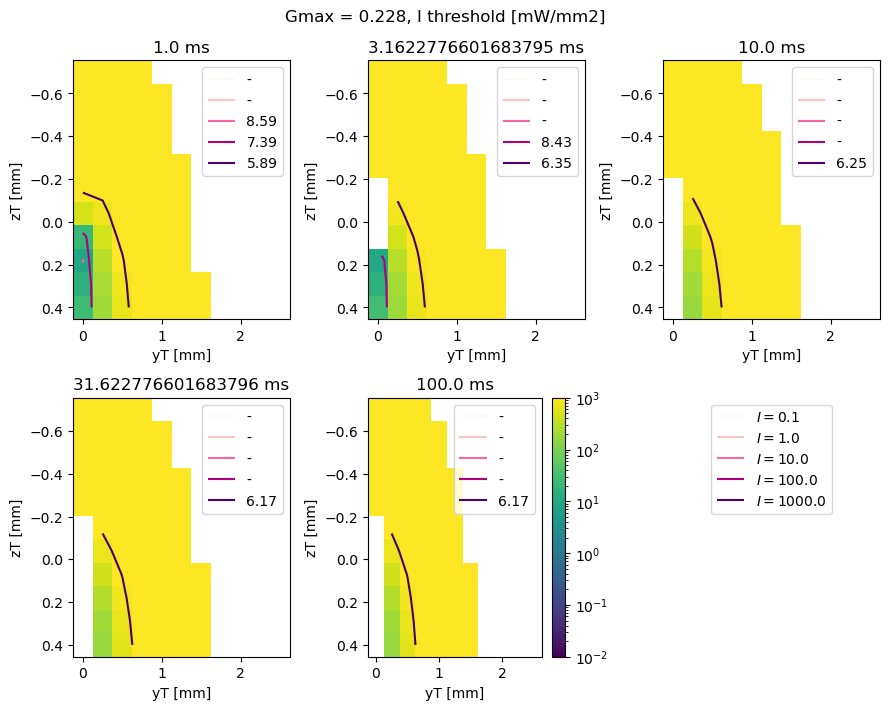

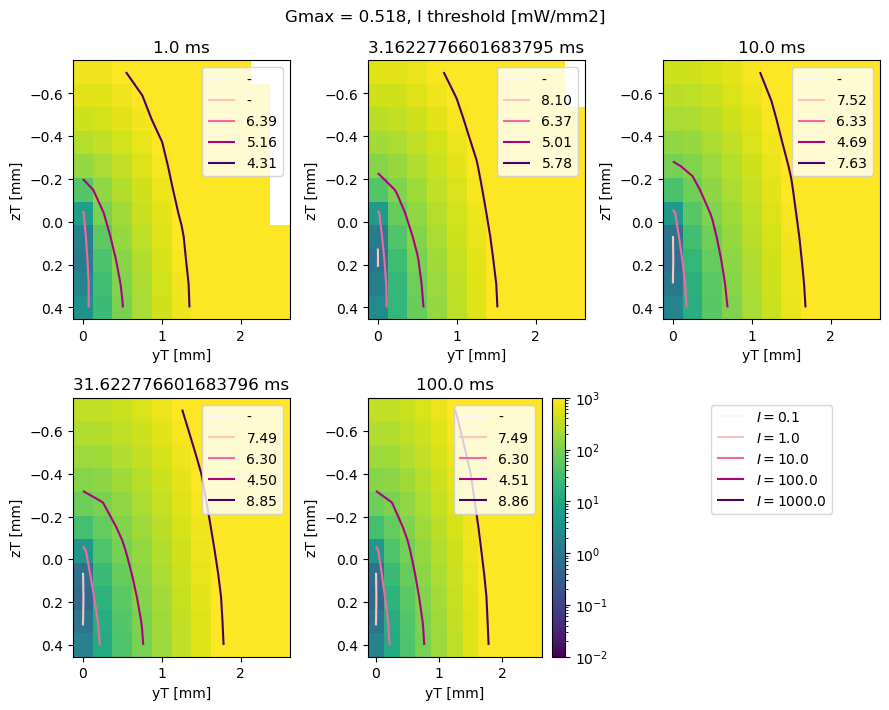

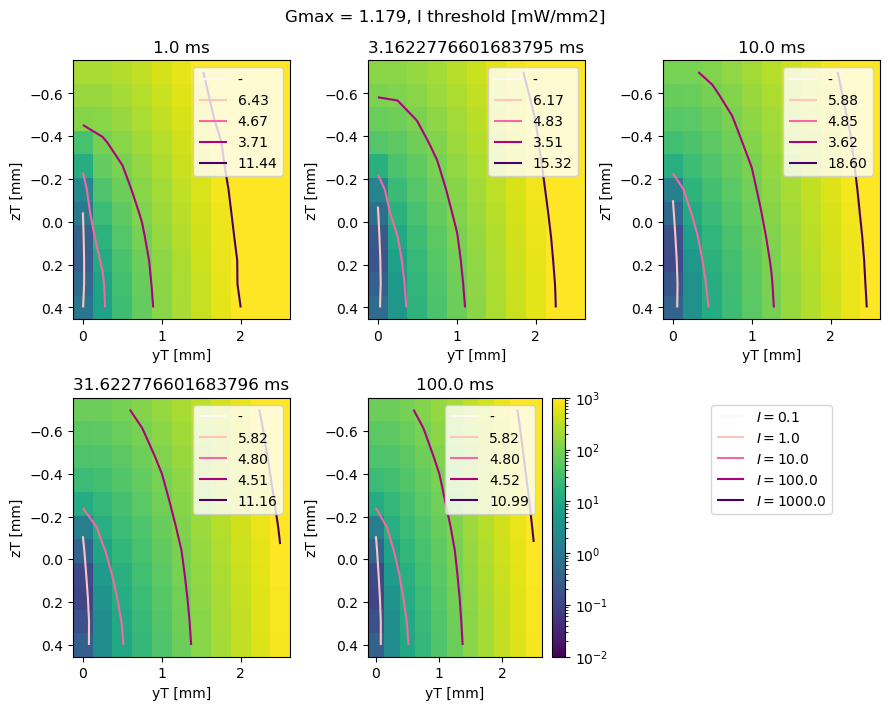

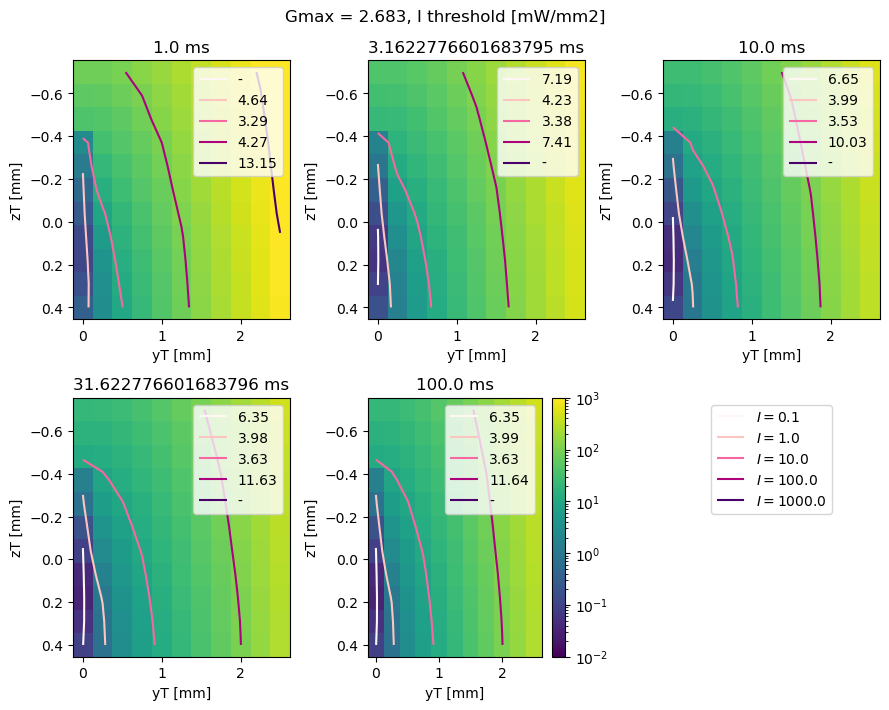

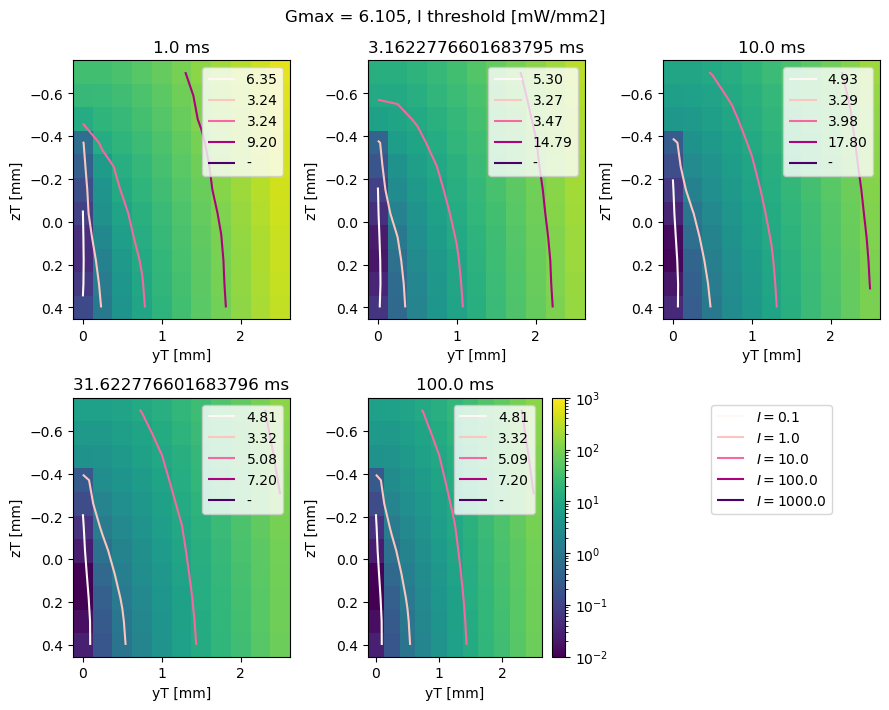

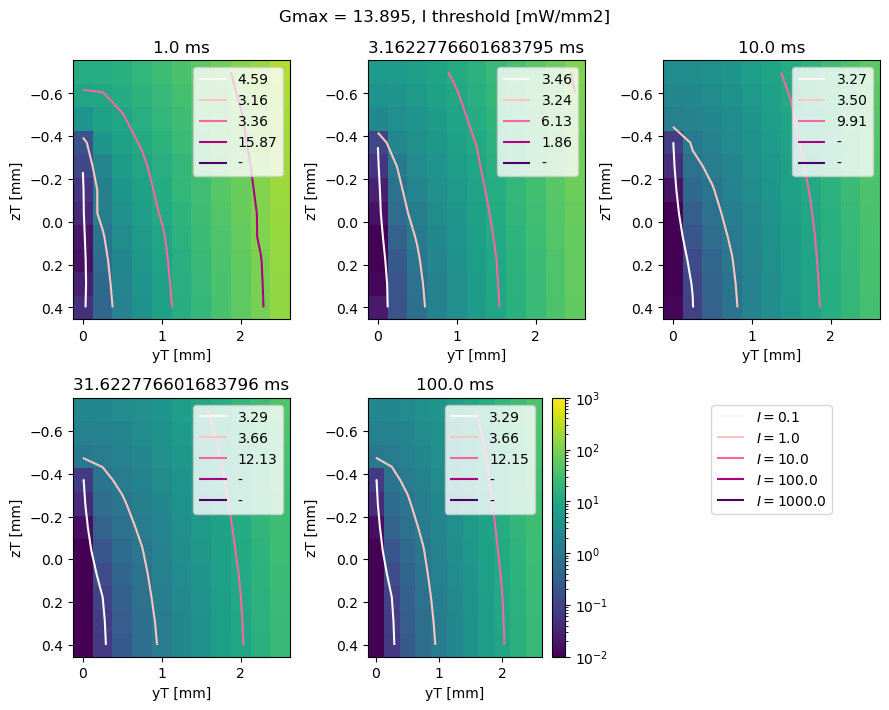

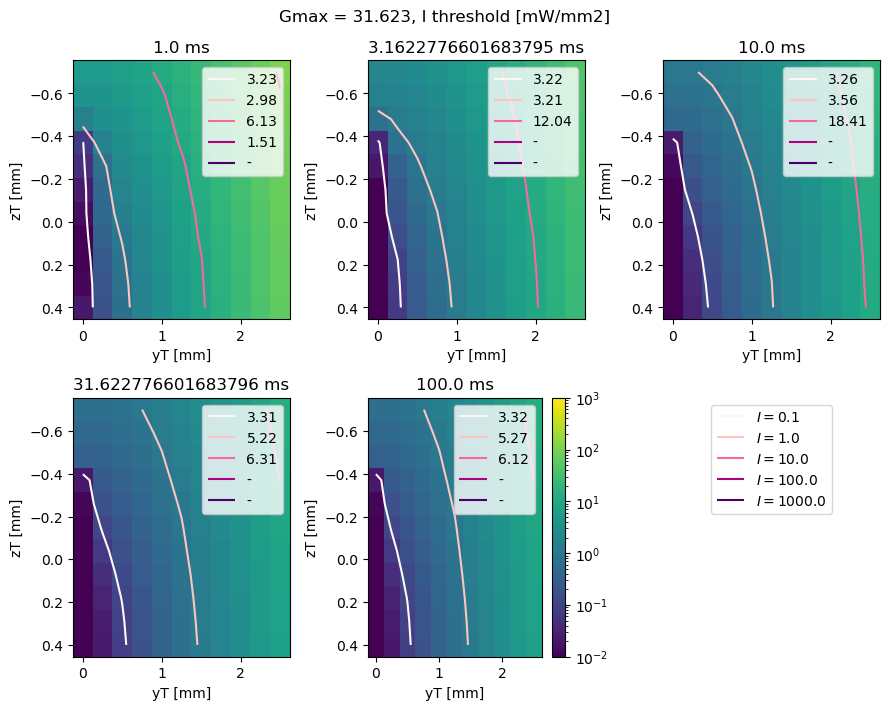

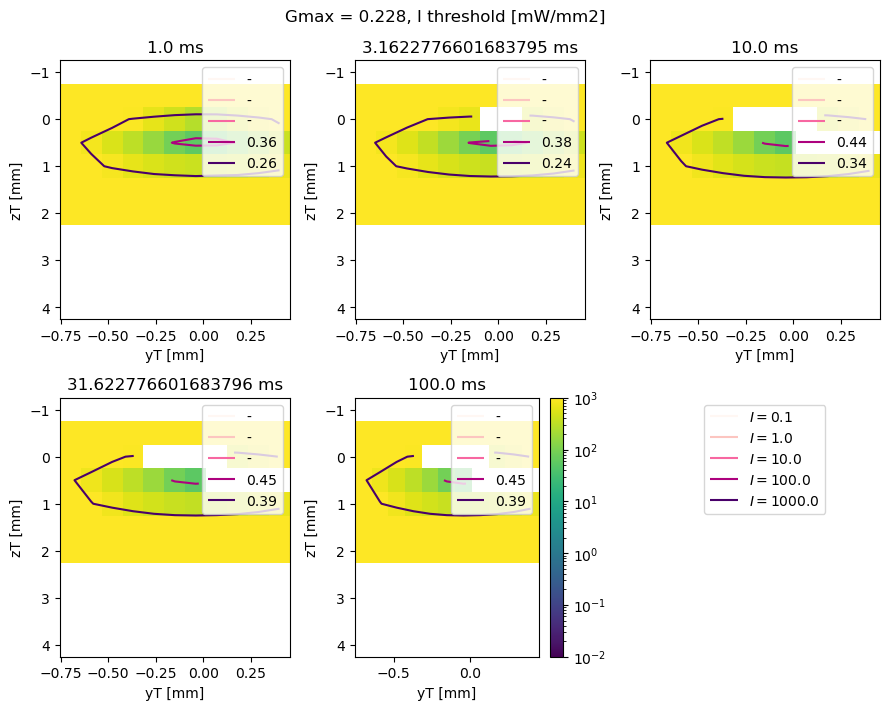

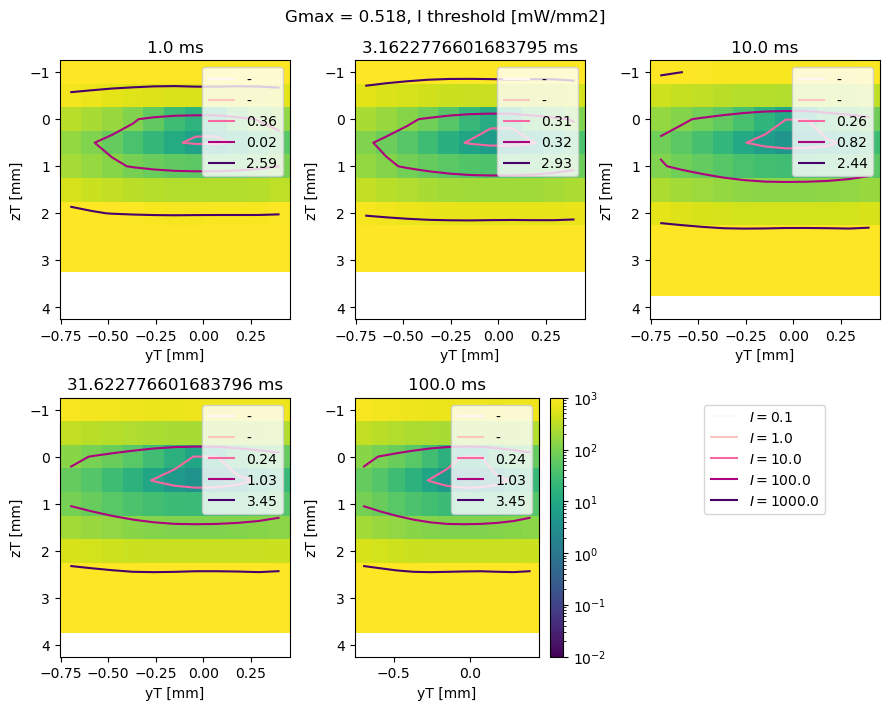

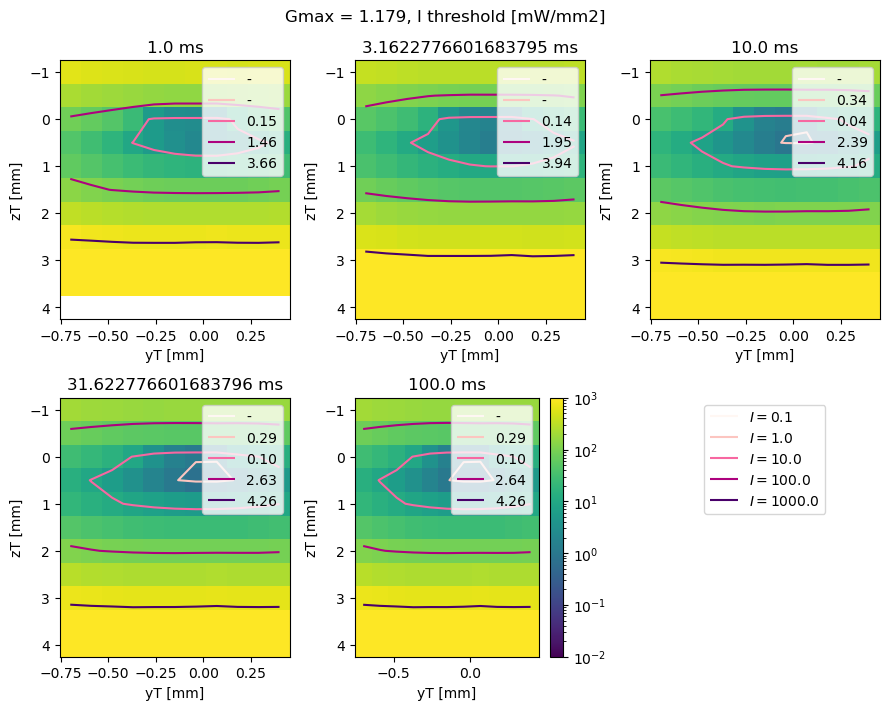

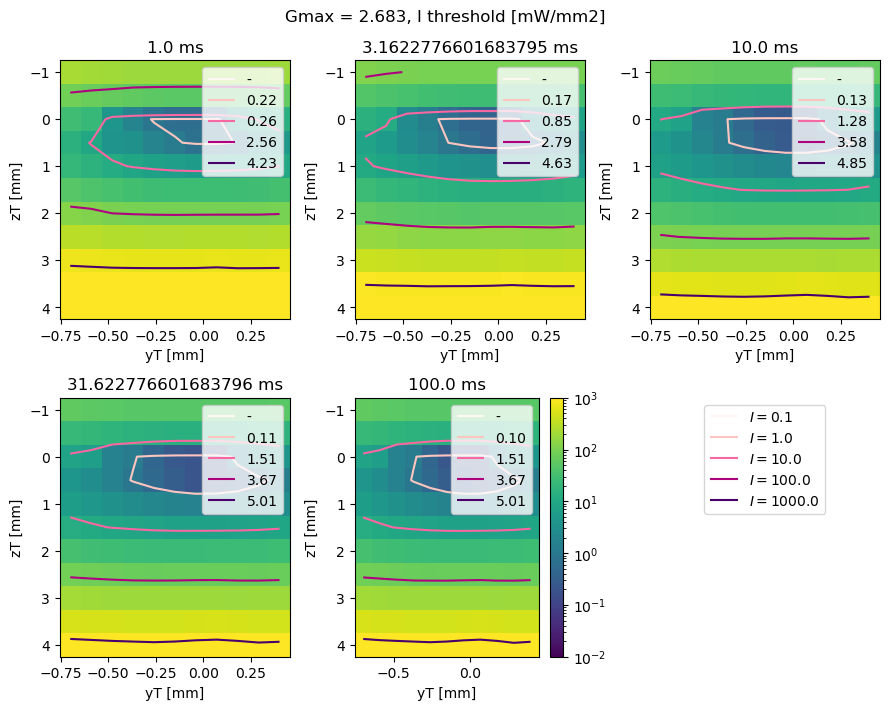

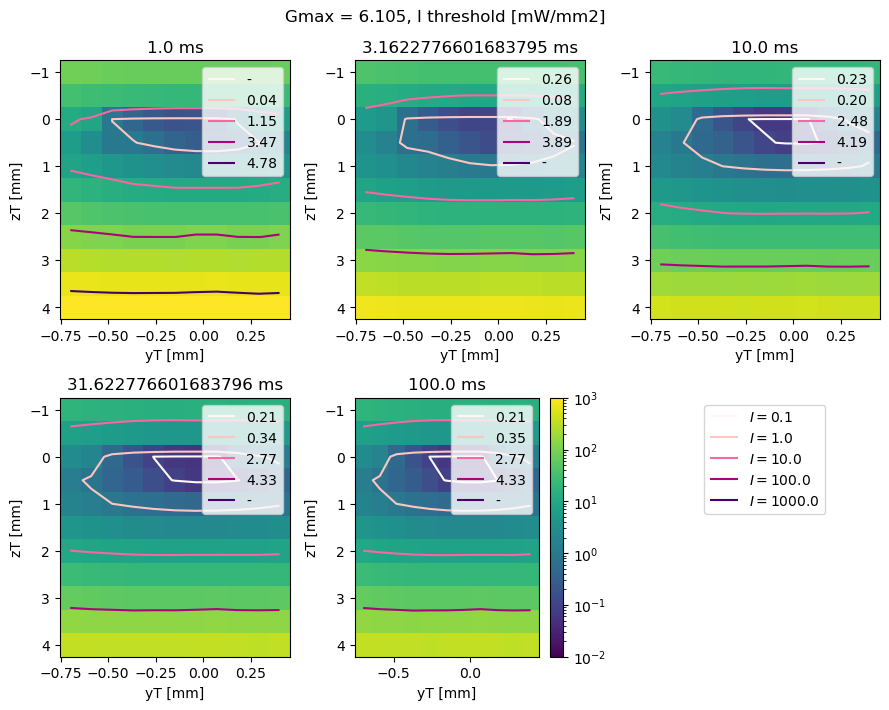

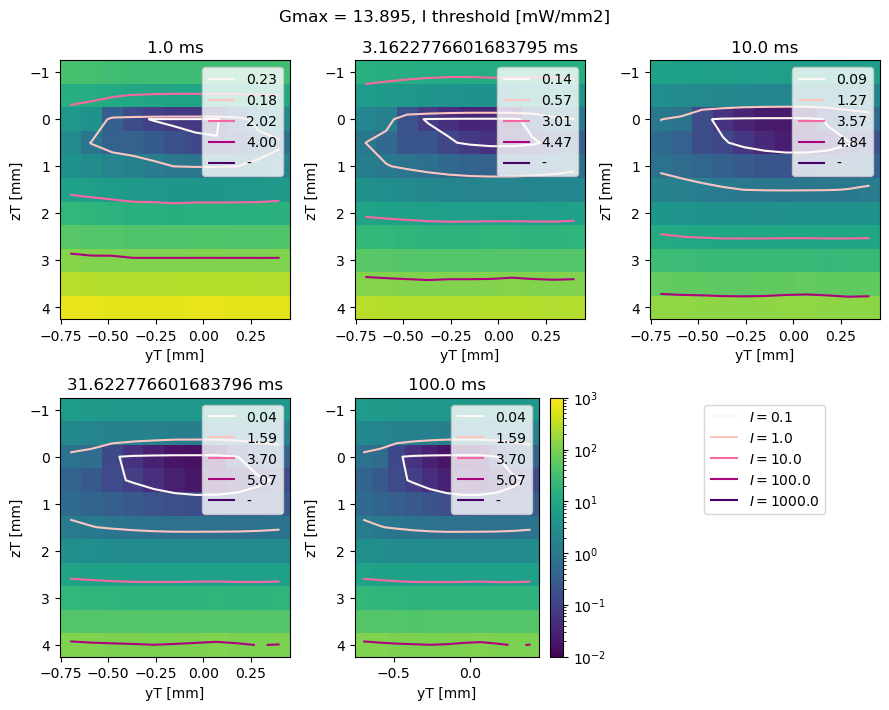

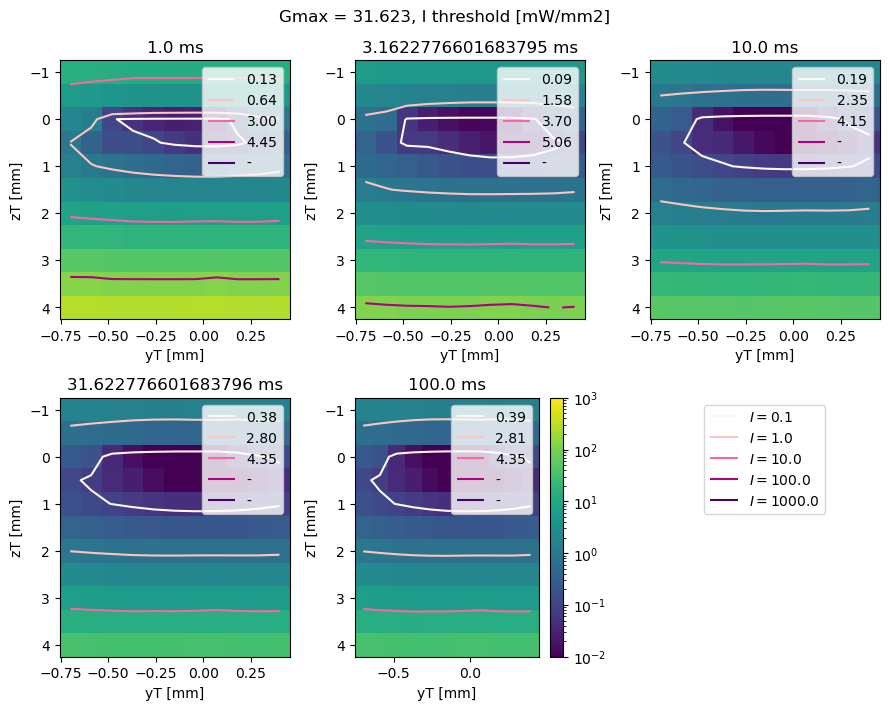

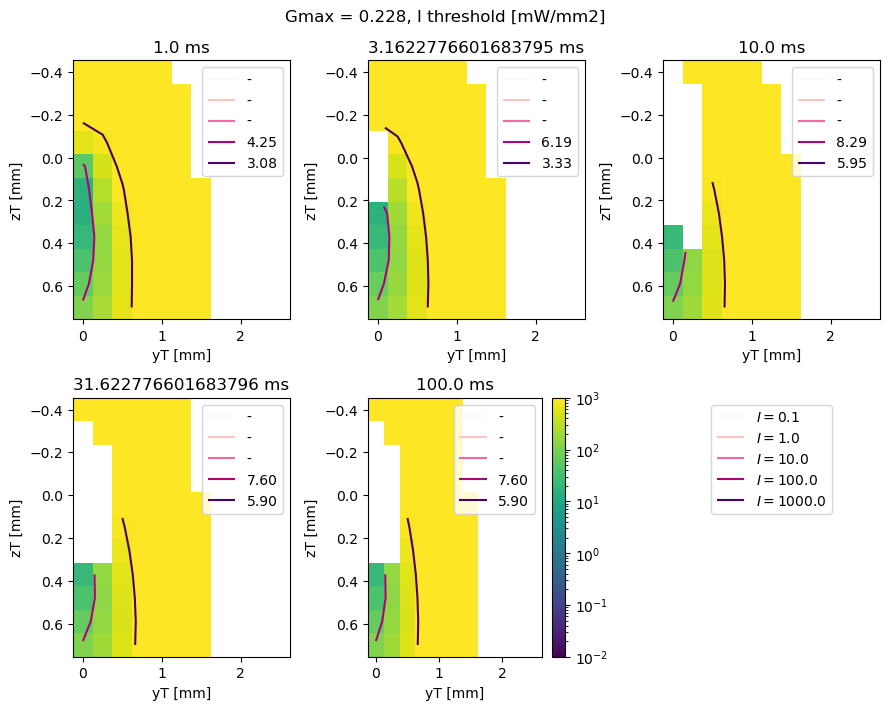

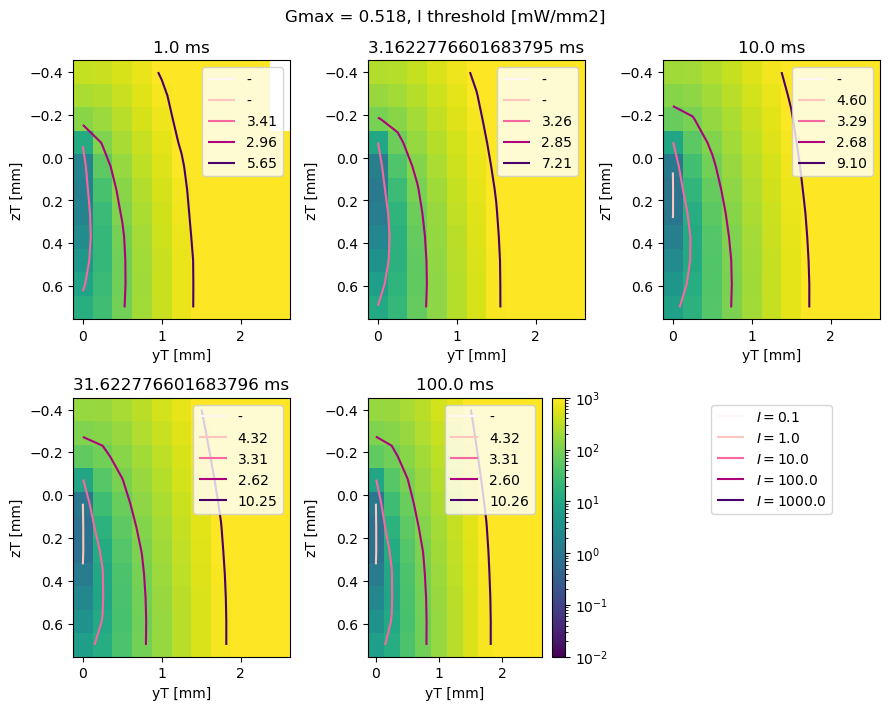

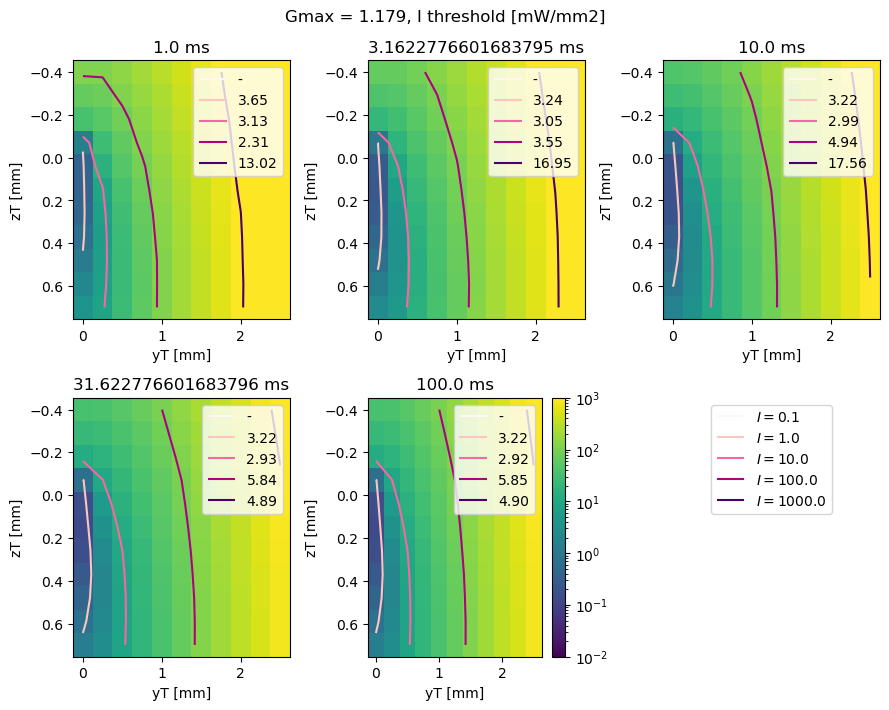

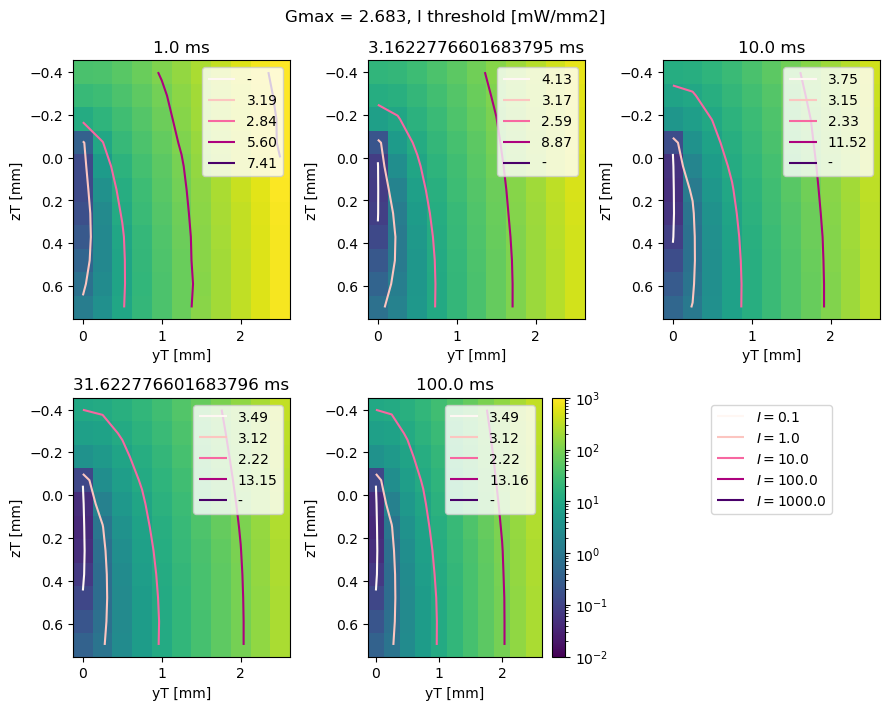

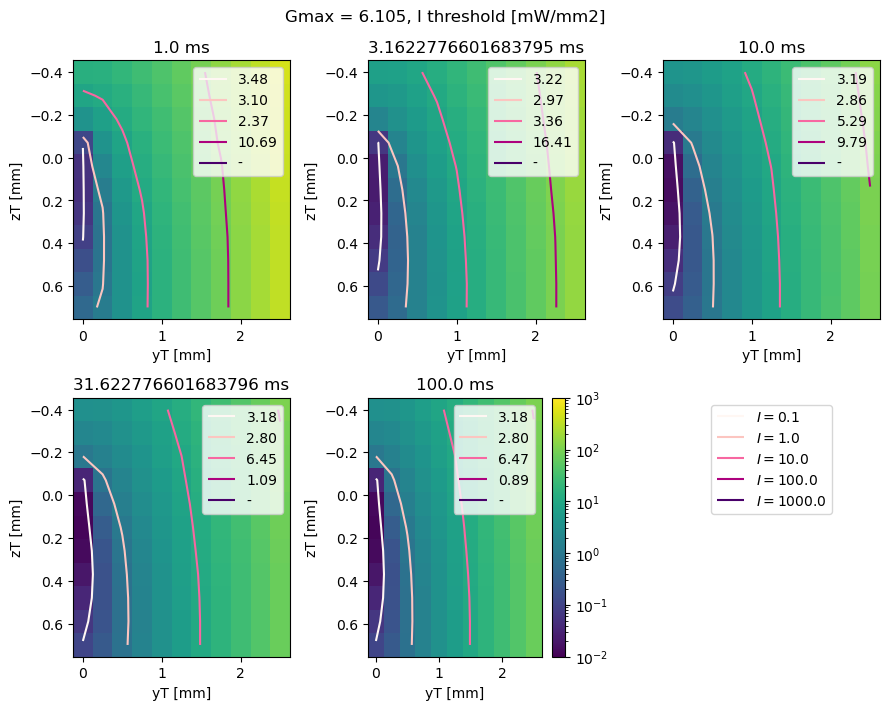

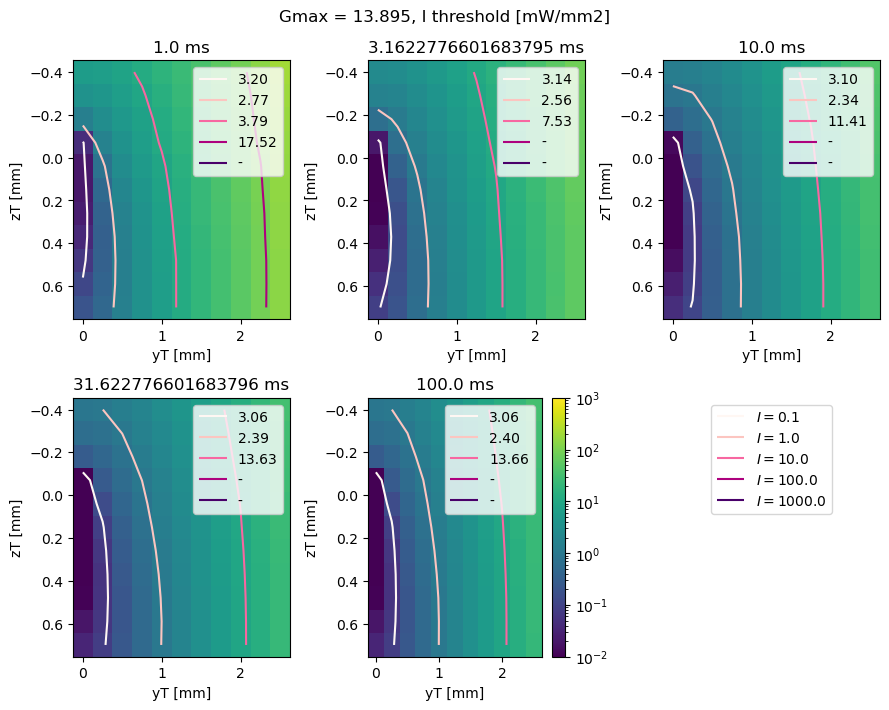

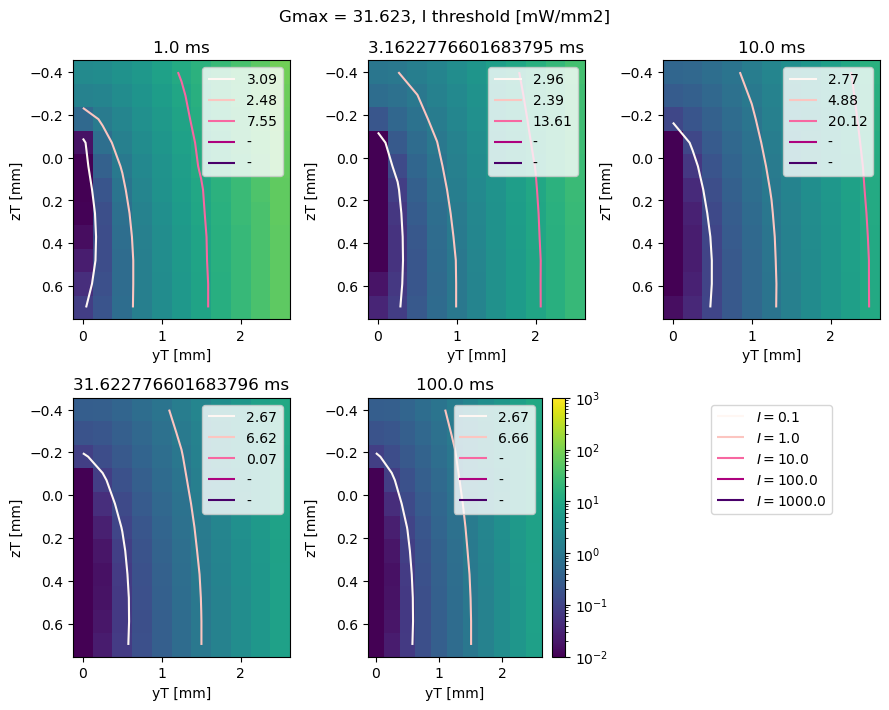

In [22]:
myselection_noGmax = {key:unique_values_columns_master[key][0] for key in [*cell_init_options,*settings_options,*opsin_options,*field_options] if not key in ['Gmax','distribution','theta_0','x_0','y_0','z_0']}
print(myselection_noGmax)
intm_df = master_df[selection_generator(master_df,unique_values_columns_master,verbose=False,**myselection_noGmax)]
gmaxs = list(intm_df['Gmax'].unique())
print_upscale = False
nan_tolerance_percentage = 0.95
for theta in unique_values_columns_master['theta_0']:
    for gmax in gmaxs[1:]:
        print(gmax)
        myselection = {**myselection_noGmax, 'Gmax': gmax,'theta_0':theta}
        single_config_df = master_df[selection_generator(master_df,unique_values_columns_master,verbose=False,**myselection)].reset_index(drop=True)
        print(myselection)

        # Imin = np.nanmin(unique_values_columns_master['amp'])
        # print(Imin)
        # Imax = np.nanmax(unique_values_columns_master['amp'])
        # print(Imax)
        levels = np.logspace(-1,3,5)
        norm_log = cm.colors.LogNorm(vmax=1000, vmin=0.01)
        norm_log_cntr = cm.colors.LogNorm(vmax=levels[-1], vmin=levels[0])


        udurs = list(single_config_df['dur'].unique())
        fig,axs = plt.subplots(int(len(udurs)/3+0.67),3,tight_layout = True,figsize=np.array([10,8])*0.9)
        all_axs = axs.ravel()
        if print_upscale:
            fig_up,axs_up = plt.subplots(int(len(udurs)/3+0.67),3,tight_layout = True,figsize=np.array([10,8])*0.9)
            all_axs = zip(axs.ravel(),axs_up.ravel())

        for dur,ax in zip(udurs,all_axs):
            if print_upscale:
                ax_up = ax[1]
                ax = ax[0]

            intm_df = single_config_df[single_config_df['dur']==dur]
            if not np.all(np.isnan(intm_df['amp'])):
                data_toplot = np.array((intm_df['x']+intm_df['x_0'],intm_df['z']+intm_df['z_0'],intm_df['amp'])).T/1000
                data_toplot = data_toplot[np.lexsort((data_toplot[:,0],data_toplot[:,1])),:]
                data_toplot = EcF.prepareDataforInterp(data_toplot,'ninterp')
                yY, zZ = np.meshgrid(np.linspace(data_toplot[0].min(),data_toplot[0].max(),len(np.unique(data_toplot[0])),endpoint=True),np.linspace(data_toplot[1].min(),data_toplot[1].max(),len(np.unique(data_toplot[0])),endpoint=True),indexing='ij')

                if sum(np.isnan(data_toplot[-1].flatten()))/len(data_toplot[-1].flatten()) < nan_tolerance_percentage:
                    im,cntr,cb = EcF.slicePlot(data_toplot,ax,fig,plotGrid=(yY,zZ),structured=True, norm=norm_log,invert_yaxis=True,contour_kwargs={'norm':norm_log_cntr,'cmap':'RdPu','levels':levels})
                    ax.set_xlabel('yT [mm]')
                    ax.set_ylabel('zT [mm]')
                    ax.set_title(f'{dur} ms')
                    cb.remove()
                    h, l = cntr.legend_elements("I")
                    vta = VTA2D(yY,zZ,im.get_array().reshape(yY.shape),grid_order=EcF.checkGridOrder(yY.ravel(),zZ.ravel()),cntrs=cntr,cntr_order='rz',intensity = levels)
                    ax.legend(h, [f'{x:0.2f}' if ~np.isnan(x) else '-' for x in vta],ncol=1,loc='upper right')

                    if print_upscale:
                        yY_up, zZ_up = np.meshgrid(np.linspace(data_toplot[0].min(),data_toplot[0].max(),40,endpoint=True),np.linspace(data_toplot[1].min(),data_toplot[1].max(),40,endpoint=True))
                        im_up,cntr_up,cb_up = EcF.slicePlot(data_toplot,ax_up,fig_up,plotGrid=(yY_up,zZ_up),structured=True, norm=norm_log,invert_yaxis=True,contour_kwargs={'norm':norm_log_cntr,'cmap':'RdPu','levels':levels})
                        ax_up.set_xlabel('yT [mm]')
                        ax_up.set_ylabel('zT [mm]')
                        ax_up.set_title(f'{dur} ms')
                        cb_up.remove()
                        h_up, l_up = cntr_up.legend_elements("I")
                        #print('\nvta')
                        #print(EcF.checkGridOrder(yY.ravel(),zZ.ravel()))
                        vta_up = VTA2D(yY_up,zZ_up,im_up.get_array().reshape(yY_up.shape),grid_order=EcF.checkGridOrder(yY_up.ravel(),zZ_up.ravel()),cntrs=cntr_up,cntr_order='rz',intensity = levels)
                        ax_up.legend(h_up, [f'{x:0.2f}' if ~np.isnan(x) else '-' for x in vta_up],ncol=1,loc='upper right')
                        #print('\nvta2')
                        #print(EcF.checkGridOrder(yY.T.ravel(),zZ.T.ravel()))
                        #vta2 = VTA2D(yY.T,zZ.T,im.get_array().reshape(yY.shape).T,grid_order=EcF.checkGridOrder(yY.T.ravel(),zZ.T.ravel()),intensity = levels,close_plot=False)
                        #if np.any((np.array(vta)-np.array(vta2))>1e-10):
                        #    print(np.array(vta)-np.array(vta2))

        fig.suptitle(f'Gmax = {gmax:0.3f}, I threshold [mW/mm2]')
        try:
            h, l = cntr.legend_elements("I")
            axs[-1,-1].legend(h, l,ncol=1,loc='upper center')
            axs[-1,-1].axis('off')
            cb = fig.colorbar(im,ax=axs[-1,-2])
        except:
            pass
        
        if print_upscale:
            fig_up.suptitle(f'Upscaled via linear interpol')
            h_up, l_up = cntr_up.legend_elements("I")
            axs_up[-1,-1].legend(h_up, l_up,ncol=1,loc='upper center')
            axs_up[-1,-1].axis('off')
            cb_up = fig_up.colorbar(im_up,ax=axs_up[-1,-2])
        print()

# Pyramidal cells
## Strength duration curve plots
- rows different Gmax
- colors different opsin position

Intensity: For long pulse durations seems to have converged to rheobase.\
TAC: at low Gmax no convergence, moroever curves of different opsin locations cross

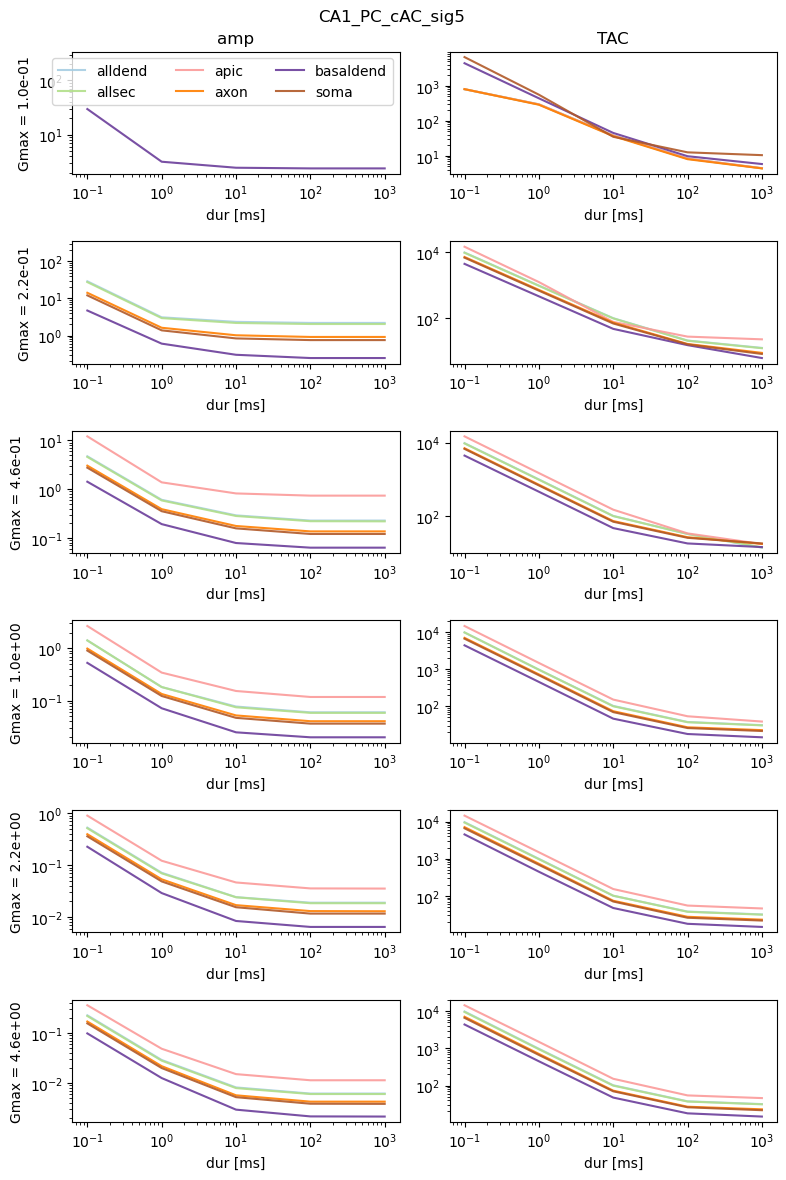

In [6]:

colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]

fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle in zip(unique_values_columns_master['neurontemplate'][:1],linestyle_str):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]
    uGmax = np.sort(fig_df['Gmax'].unique())[3:-4]
    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique()]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ax.plot(xdata,ydata,color=clr,alpha=0.9,linestyle=linestyle,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

## STATISTICS
Pooled all simulations together\
Check if categories (neurontemplate, opsinlocations, Gmax and dur) give different results\


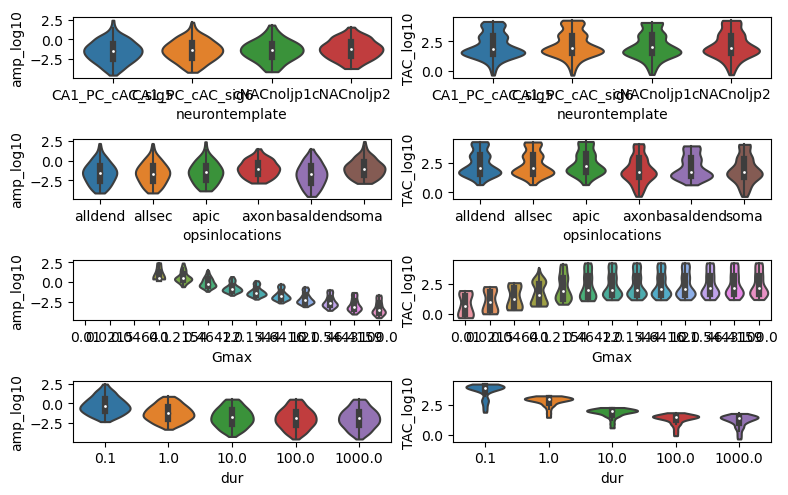

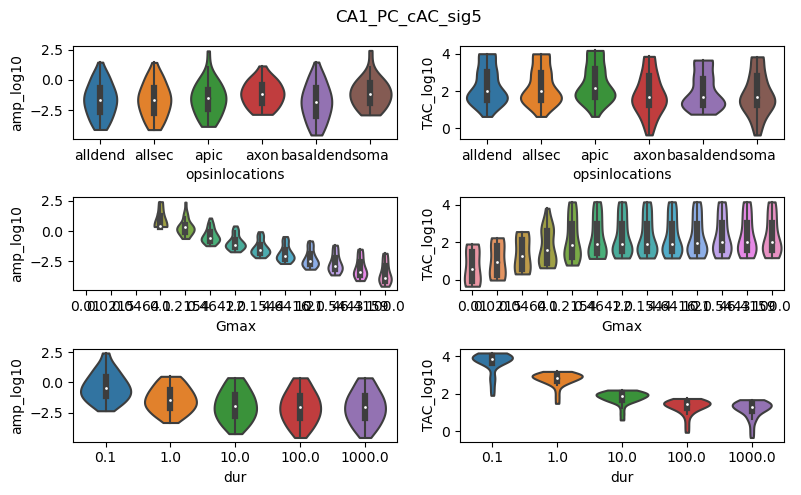

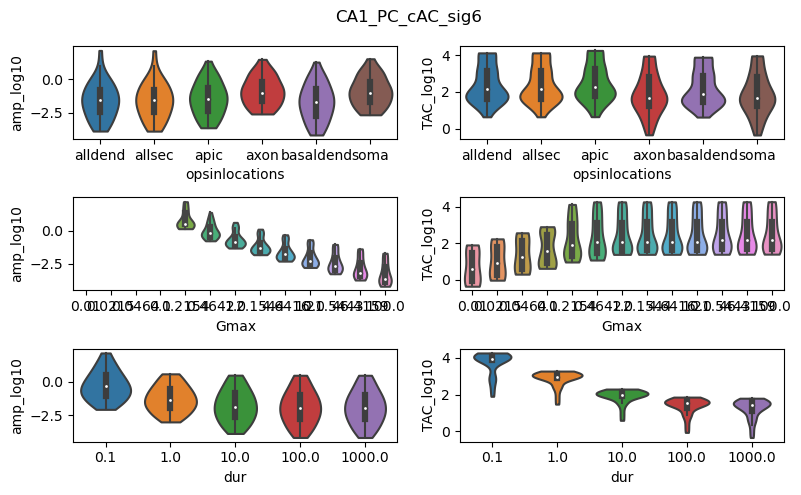

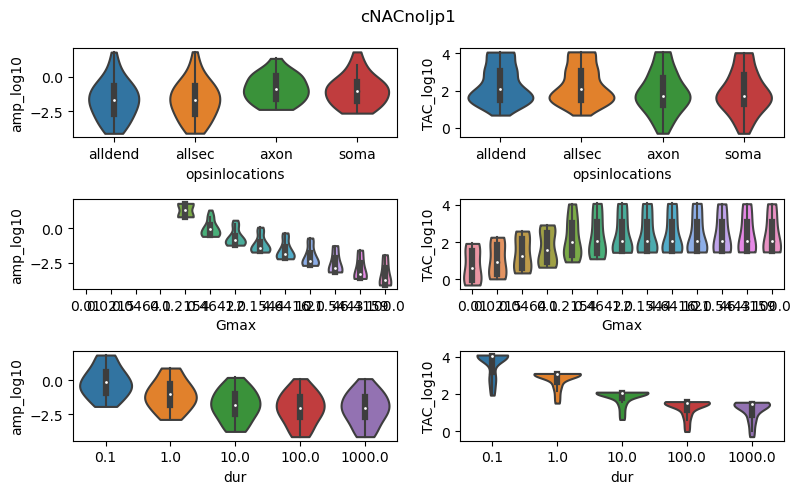

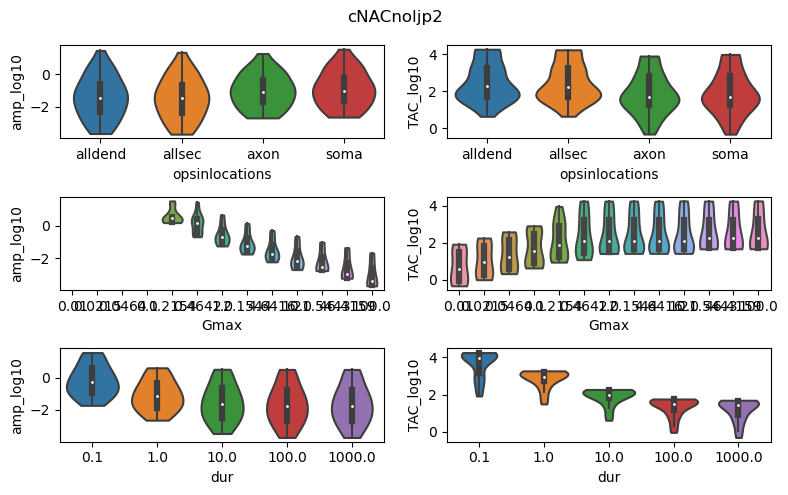

In [7]:
fig,axs = plt.subplots(4,2,tight_layout = True,figsize=(8,5))
for i,pool in enumerate(['neurontemplate','opsinlocations','Gmax','dur']):
    sns.violinplot(data=master_df,y='amp_log10',x=pool,ax=axs[i,0],cut=0)
    sns.violinplot(data=master_df,y='TAC_log10',x=pool,ax=axs[i,1],cut=0)
for nt in unique_values_columns_master['neurontemplate']:
    idx = master_df['neurontemplate']==nt
    fig,axs = plt.subplots(3,2,tight_layout = True,figsize=(8,5))
    for i,pool in enumerate(['opsinlocations','Gmax','dur']):
        sns.violinplot(data=master_df[idx],y='amp_log10',x=pool,ax=axs[i,0],cut=0)
        sns.violinplot(data=master_df[idx],y='TAC_log10',x=pool,ax=axs[i,1],cut=0)
    fig.suptitle(nt)

### Kruskal-Wallis H-test

{'amp_log10': {'all': {'neurontemplate': (3.979652086241692, 0.2636697364534318), 'opsinlocations': (39.30807522427982, 2.058766367964106e-07), 'Gmax': (556.3422355116936, 2.1980918587907923e-111), 'dur': (164.7515698167895, 1.3985922175123615e-34), 'Gmax_log10': (556.3422355116936, 2.1980918587907923e-111)}}, 'TAC_log10': {'all': {'neurontemplate': (2.6197714213442813, 0.45403389986110654), 'opsinlocations': (67.61191991848679, 3.215403966609888e-13), 'Gmax': (162.7849489643435, 1.4210493523338217e-28), 'dur': (782.4318158221737, 4.90473068633569e-168), 'Gmax_log10': (162.7849489643435, 1.4210493523338217e-28)}}}


Text(0.5, 1.0, 'Kruskal Wallis')

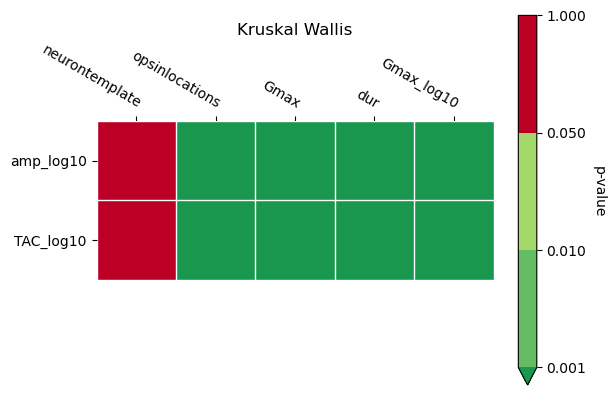

In [8]:
colors = np.array([[189,0,38],[166,217,106],[102,189,99],[26,152,80]])/256
colors = np.flipud(colors)
cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=colors.shape[0])
boundaries  = [0.001,0.01,0.05,1.0]
boundnorm = cm.colors.BoundaryNorm(boundaries,len(boundaries),extend='min')

KW_dict = {}
features = ['amp_log10','TAC_log10']
classes = ['neurontemplate','opsinlocations','Gmax','dur','Gmax_log10']
for feat in features:
    KW_dict[feat] = {'all':{}}
    for pool in classes:
        pooledData = [list(master_df[feat][master_df[pool]==ukey]) for ukey in unique_values_columns_master[pool]]
        KW_dict[feat]['all'][pool] = stats.kruskal(*pooledData,nan_policy='omit')[:]
print(KW_dict)

heatmapdata = np.zeros((len(features),len(classes)))
for ifeat,feat in enumerate(features):
    for ipool,pool in enumerate(classes):
        heatmapdata[ifeat,ipool] = KW_dict[feat]['all'][pool][1]

fig,ax= plt.subplots(1,1)
heatmap(heatmapdata,features,classes,ax=ax,norm=boundnorm,cmap=cmap,cbarlabel='p-value')
ax.set_title('Kruskal Wallis')

### Mann Whitney U Test and Wilcoxon signed-rank test
WSRT: hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero.

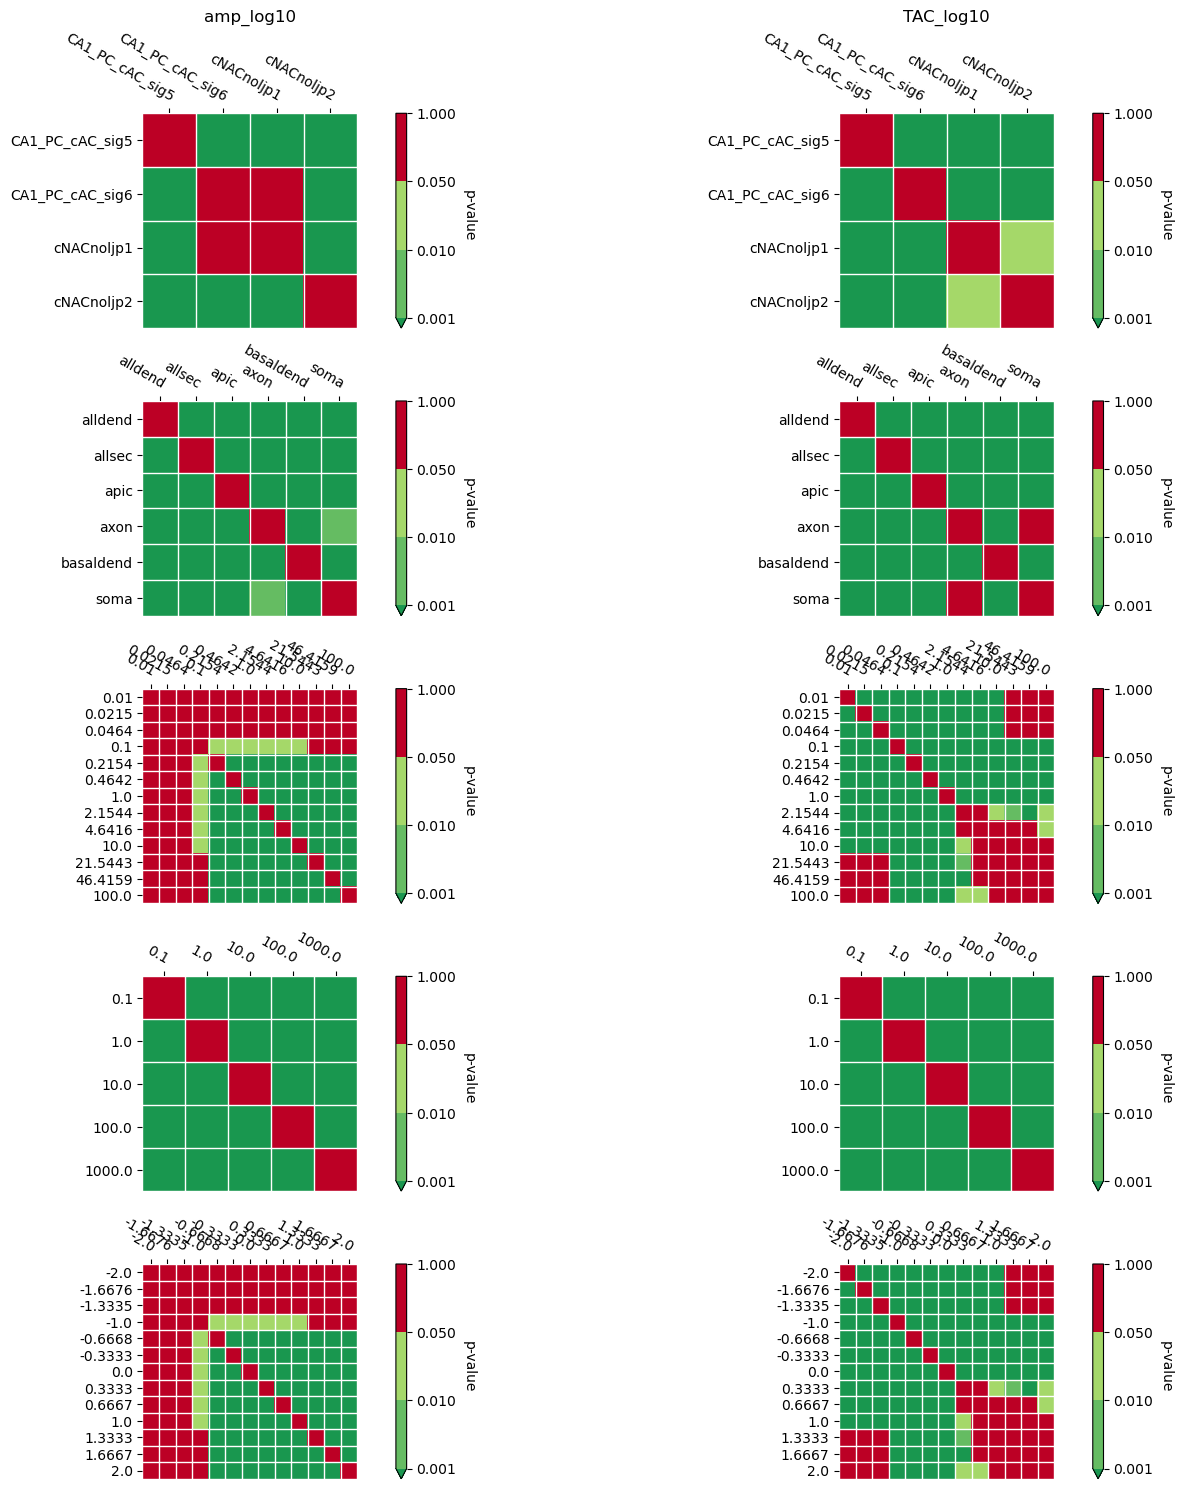

In [32]:
MWU_dict = {}
WSRT_dict = {}
for feat in features:
    MWU_dict[feat] = {'all':{}}
    WSRT_dict[feat] = {'all':{}}
    for pool in classes:
        ukeys =  unique_values_columns_master[pool]
        mytest_MWU = np.ones((len(ukeys),len(ukeys),2))
        mytest_WSRT = np.ones((len(ukeys),len(ukeys),2))
        for i in range(len(ukeys)):
            for j in range(len(ukeys)):
                x = np.array(master_df[feat][master_df[pool]==ukeys[i]])
                x = x[~np.isnan(x)]
                y = np.array(master_df[feat][master_df[pool]==ukeys[j]])
                y = y[~np.isnan(y)]
                if len(y)>0 and len(x)>0:
                    mytest_MWU[i,j,0] = stats.mannwhitneyu(x,y)[0]
                    mytest_MWU[i,j,1] = stats.mannwhitneyu(x,y)[1]

                df1 = master_df[master_df[pool]==ukeys[i]]
                df2 = master_df[master_df[pool]==ukeys[j]]
                df1 = df1.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                df2 = df2.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
                diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~np.isnan(xydiff)]
                if  len(xydiff)>0 and i!=j:
                    mytest_WSRT[i,j,0] = stats.wilcoxon(xydiff)[0]
                    mytest_WSRT[i,j,1] = stats.wilcoxon(xydiff)[1]
        MWU_dict[feat]['all'][pool] = mytest_MWU
        WSRT_dict[feat]['all'][pool] = mytest_WSRT

fig,axs = plt.subplots(len(classes),2,tight_layout=True,figsize=(15,15))
for pool,ax in zip(classes,axs):
    ukeys =  unique_values_columns_master[pool]
    for ifeat,feat in enumerate(features):
        #im,_ = heatmap(MWU_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat*2], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        im,_ = heatmap(WSRT_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        if pool==classes[0]:
            ax[ifeat].set_title(feat)

### Same test split over cells
From results below (see ratio wrt to soma) would have suspected soma vs axon and alldend vs allsec would not be statistically significant!

c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties.

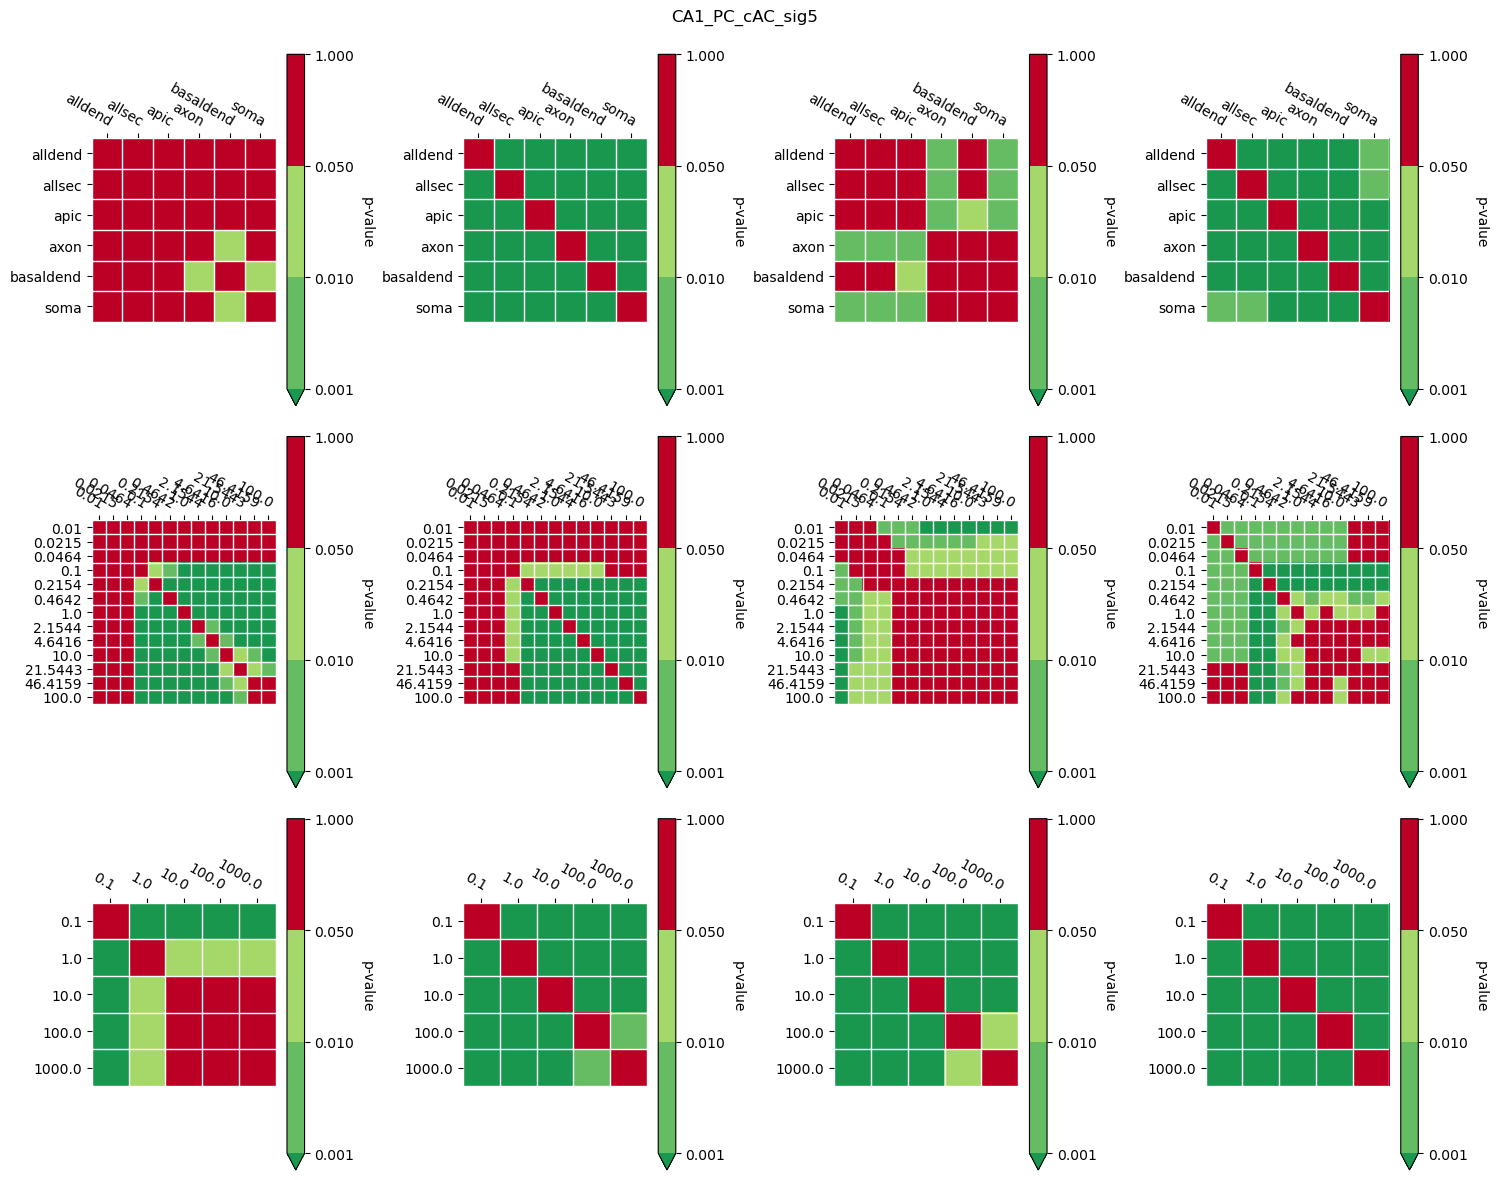

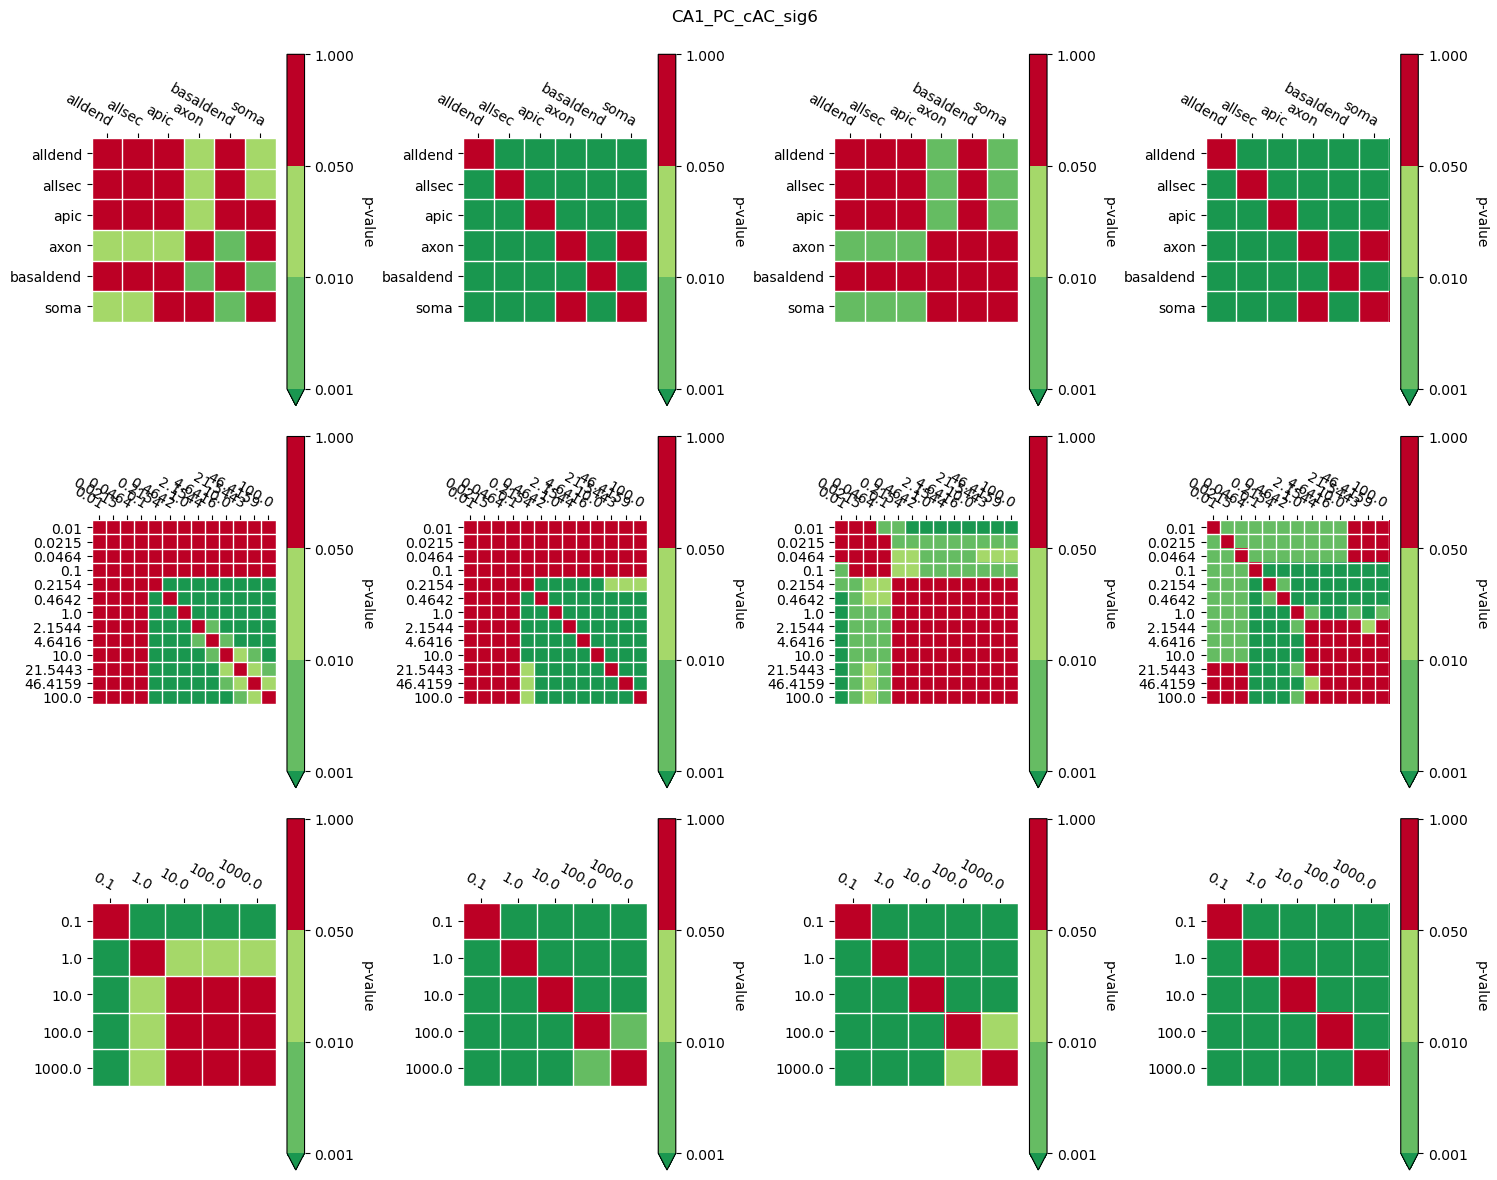

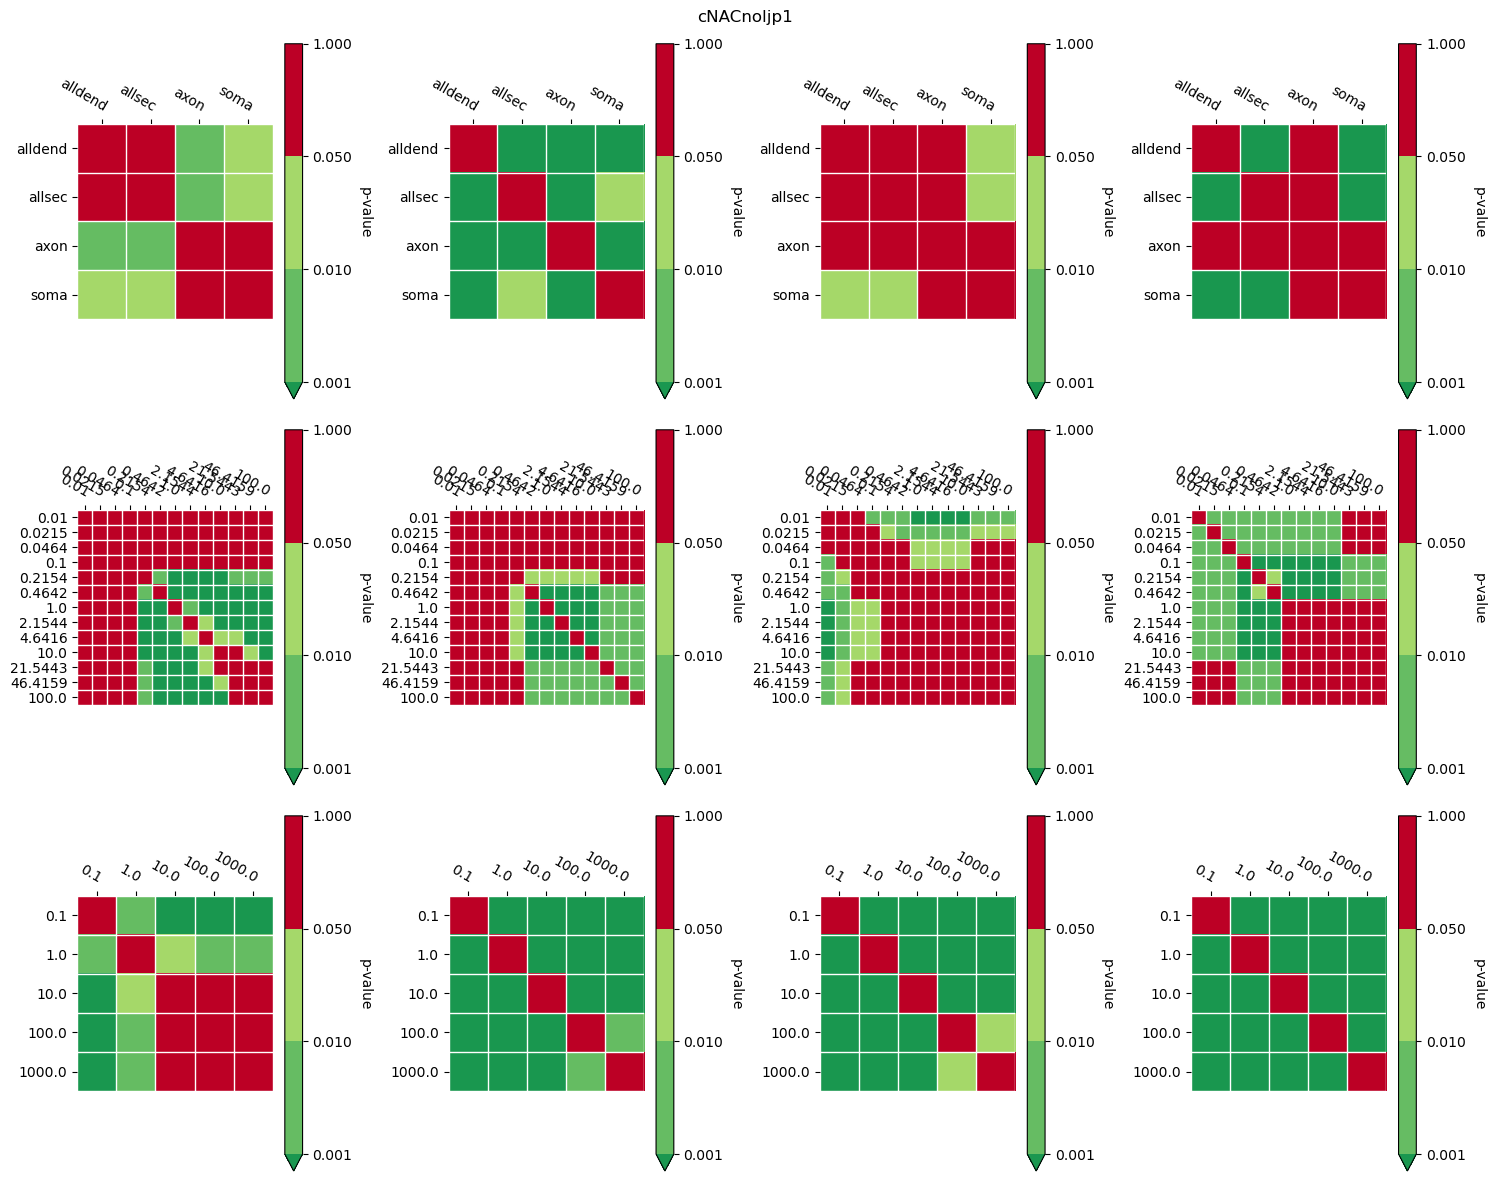

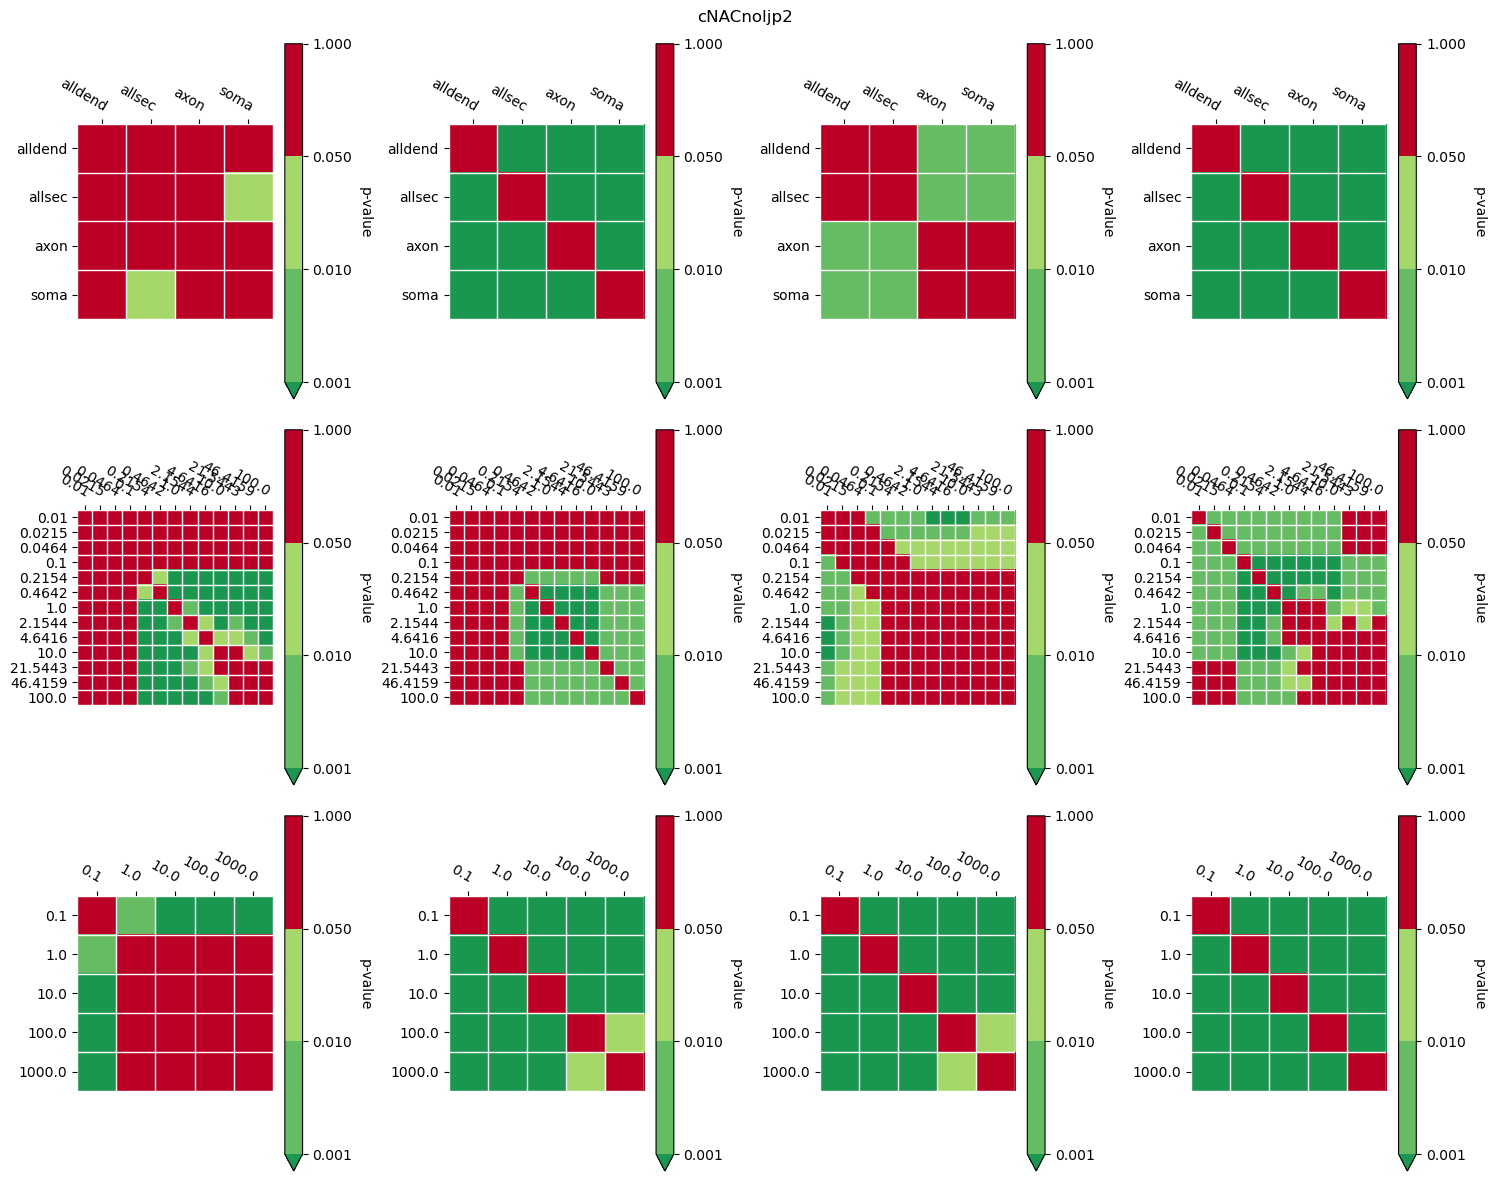

In [10]:

subclasses = ['opsinlocations', 'Gmax', 'dur']
for cell in unique_values_columns_master['neurontemplate'][:]:
    intm_df = master_df[master_df['neurontemplate']==cell]
    for feat in features:
        MWU_dict[feat][cell] = {}
        WSRT_dict[feat][cell] = {}
        for pool in subclasses:
            if pool == 'opsinlocations':
                ukeys = intm_df[pool].unique()
            else:
                ukeys = unique_values_columns_master[pool]
            mytest_MWU = np.ones((len(ukeys),len(ukeys),2))
            mytest_WSR = np.ones((len(ukeys),len(ukeys),2))
            for i in range(len(ukeys)):
                for j in range(len(ukeys)):
                    #MWU
                    x = np.array(intm_df[feat][intm_df[pool]==ukeys[i]])
                    x = x[~np.isnan(x)]
                    y = np.array(intm_df[feat][intm_df[pool]==ukeys[j]])
                    y = y[~np.isnan(y)]
                    if len(y)>0 and len(x)>0:
                        mytest_MWU[i,j,0] = stats.mannwhitneyu(x,y)[0]
                        mytest_MWU[i,j,1] = stats.mannwhitneyu(x,y)[1]
                    #WSRT
                    df1 = intm_df[intm_df[pool]==ukeys[i]]
                    df2 = intm_df[intm_df[pool]==ukeys[j]]
                    df1 = df1.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                    df2 = df2.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                    diff_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
                    diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                    xydiff = np.array(diff_df)
                    xydiff = xydiff[~np.isnan(xydiff)]
                    if  len(xydiff)>0 and i!=j:
                        mytest_WSR[i,j,0] = stats.wilcoxon(xydiff,zero_method='wilcox')[0]
                        mytest_WSR[i,j,1] = stats.wilcoxon(xydiff,zero_method='wilcox')[1]

            MWU_dict[feat][cell][pool] = mytest_MWU
            WSRT_dict[feat][cell][pool] = mytest_WSR

    fig,axs = plt.subplots(len(subclasses),4,tight_layout=True,figsize=(15,12))
    for pool,ax in zip(subclasses,axs):
        if pool == 'opsinlocations':
            ukeys = intm_df[pool].unique()
        else:
            ukeys =  unique_values_columns_master[pool]
        for ifeat,feat in enumerate(features):
            im,_ = heatmap(MWU_dict[feat][cell][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat*2], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
            im,_ = heatmap(WSRT_dict[feat][cell][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat*2+1], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
            if pool==classes[0]:
                ax[ifeat].set_title(feat)
    fig.suptitle(cell)

Gmax lower pvalues when comparison with higher Gmax (see Gmax == 100 vs Gmax == 0.4642)

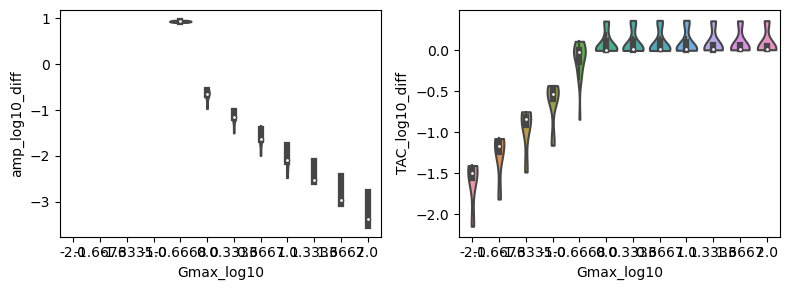

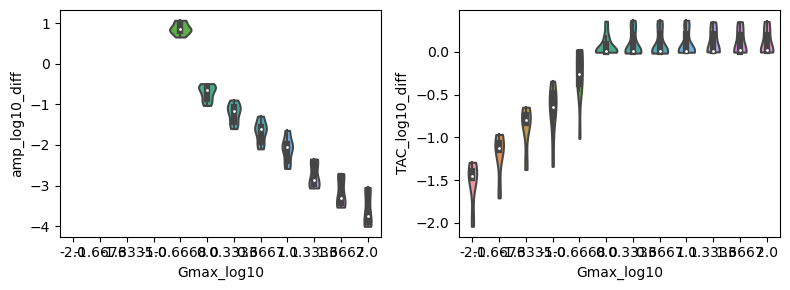

In [11]:
for nt in unique_values_columns_master['neurontemplate'][2:]:
    intm_df = master_df[master_df['neurontemplate']==nt]
    df1 = intm_df[intm_df['Gmax']==0.4642]
    df2 = intm_df[intm_df['Gmax']!=0.4642]
    df1 = df1.set_index(['opsinlocations','dur'])[['amp_log10','TAC_log10',]]
    df2 = df2.set_index(['opsinlocations','dur'])[['amp_log10','TAC_log10','Gmax_log10']]
    diff_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
    for feat in ['amp_log10','TAC_log10']:
        diff_df[feat+'_diff'] = diff_df[feat+'_1']-diff_df[feat+'_0']
    diff_df.reset_index(inplace=True)
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,3))
    sns.violinplot(data=diff_df,y='amp_log10_diff',x='Gmax_log10',ax=axs[0],cut=0)
    sns.violinplot(data=diff_df,y='TAC_log10_diff',x='Gmax_log10',ax=axs[1],cut=0)

## ratio Strength duration curves relative to soma SDC

Observation:\
- almost constant over duration / except TAC at high pulse durations
- basal dend best location, apical worst

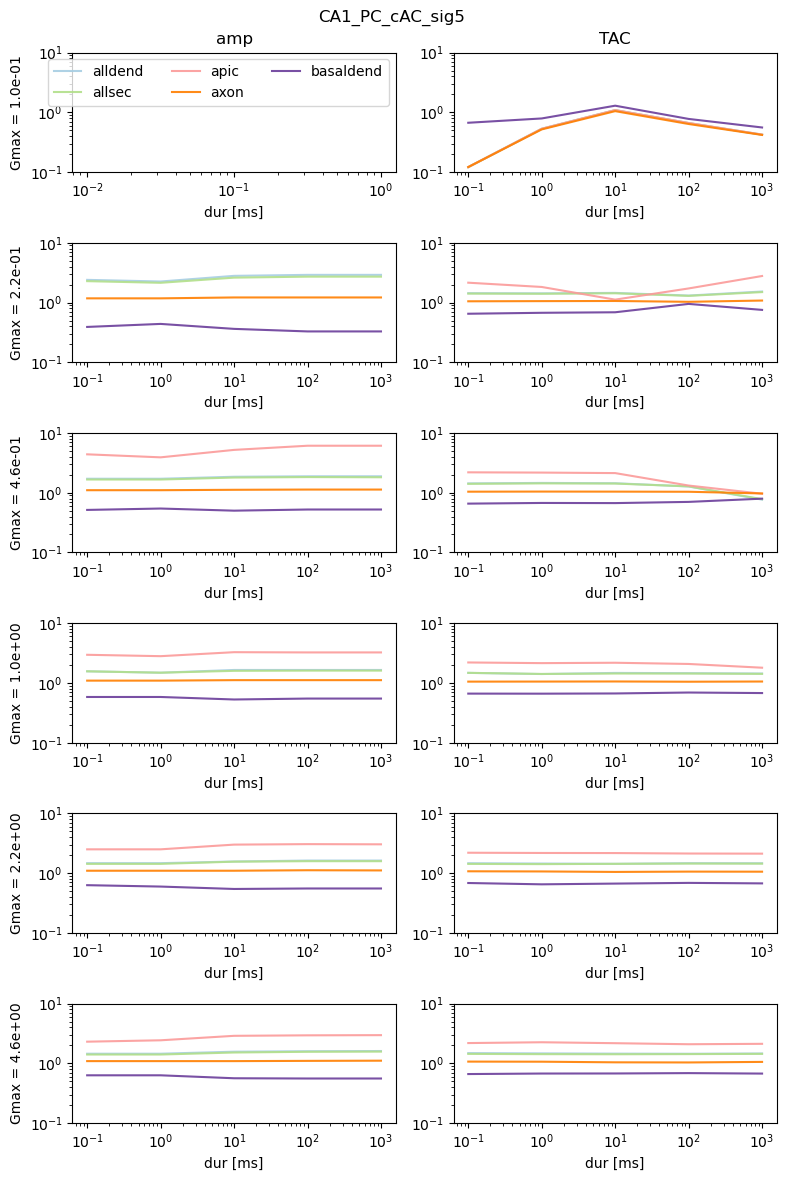

In [12]:
reference = 'soma'
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle,alpha in zip(unique_values_columns_master['neurontemplate'][:1],linestyle_str,[0.9,0.7]):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]


    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                if len(ydata)==len(ref_ydata):
                    ydata = np.array(ydata)/np.array(ref_ydata)
                    ax.plot(xdata,ydata,color=clr,alpha=alpha,linestyle=linestyle,label=oL)
                    if sum(~ np.isnan(ydata))>0:
                        logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_ylim([0.1,10])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

## Curve fit of Gmax
https://www.khanacademy.org/math/ap-statistics/inference-slope-linear-regression/inference-slope/v/confidence-interval-slope
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html


amp_log10
Rsquared: 0.7330762541955047
slope (95%): -1.413779 +/- 0.061442
intercept (95%): -0.610660 +/- 0.060075

TAC_log10
Rsquared: 0.001142901675368939
slope (95%): 0.042522 +/- 0.090537
intercept (95%): 2.404027 +/- 0.088523


 CA1_PC_cAC_sig5

amp_log10
Rsquared: 0.7459209242317499
slope (95%): -1.398038 +/- 0.103752
intercept (95%): -0.794720 +/- 0.103036

TAC_log10
Rsquared: 0.001534299980965598
slope (95%): 0.046280 +/- 0.150121
intercept (95%): 2.298075 +/- 0.149085


 CA1_PC_cAC_sig6

amp_log10
Rsquared: 0.7502479554204959
slope (95%): -1.426128 +/- 0.108096
intercept (95%): -0.532980 +/- 0.108493

TAC_log10
Rsquared: 0.0015645291235389675
slope (95%): 0.049505 +/- 0.164293
intercept (95%): 2.443186 +/- 0.164896


 cNACnoljp1

amp_log10
Rsquared: 0.7353847785143636
slope (95%): -1.516455 +/- 0.155423
intercept (95%): -0.505377 +/- 0.146939

TAC_log10
Rsquared: 0.004146182381179631
slope (95%): -0.087302 +/- 0.231172
intercept (95%): 2.531308 +/- 0.218552


 cNACnoljp2

amp

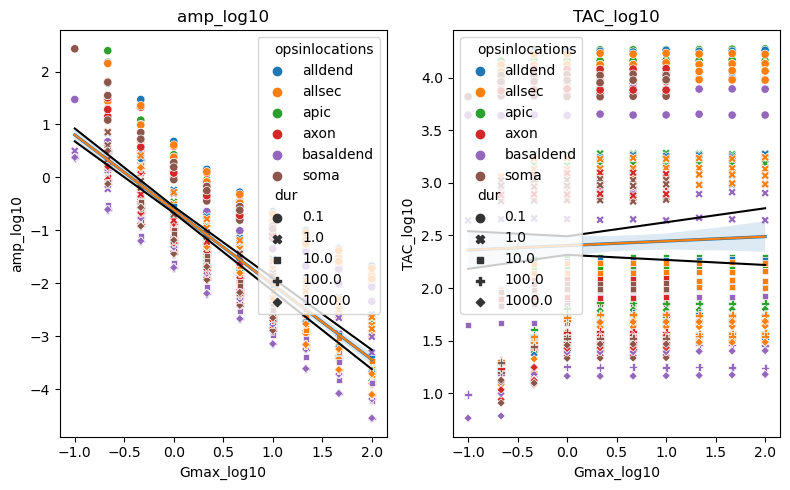

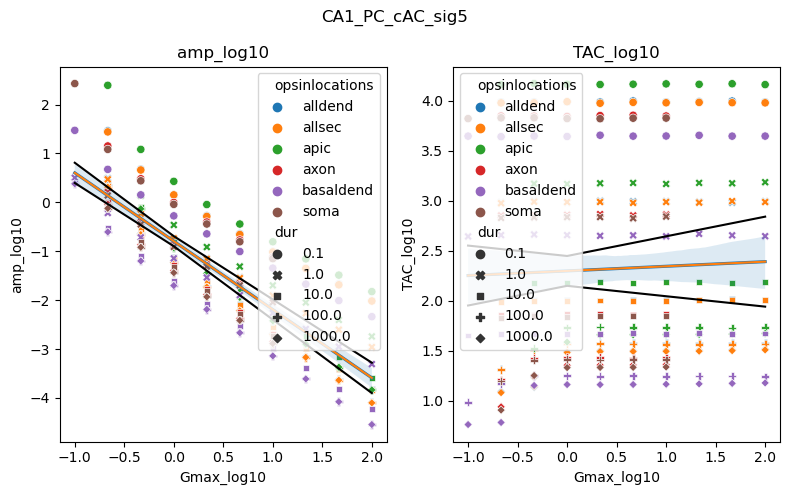

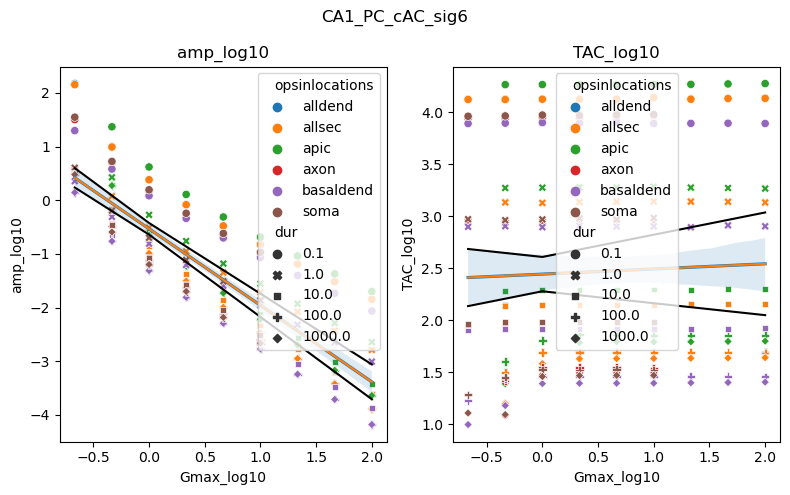

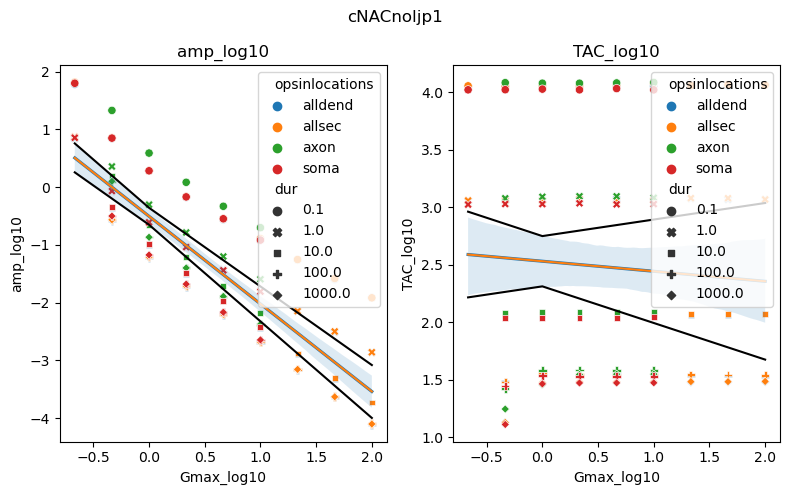

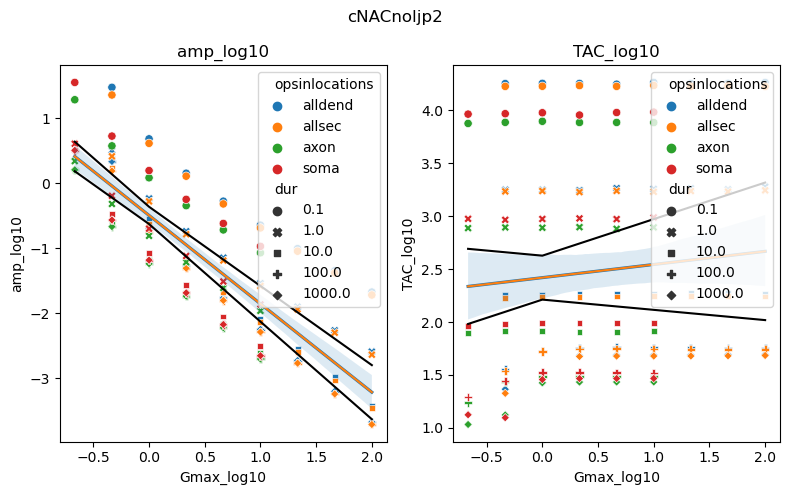

In [13]:


ress_dict = {'amp_log10':{},'TAC_log10':{}}
fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
filteronthreshold = True
ress = linearReg(master_df,['amp_log10','TAC_log10'],axs,filteronthreshold)
ress_dict['amp_log10']['all'] = ress[0]
ress_dict['TAC_log10']['all'] = ress[1]
for cell in unique_values_columns_master['neurontemplate']:
    intm_df = master_df[master_df['neurontemplate']==cell]
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    print('\n\n',cell)
    ress = linearReg(intm_df,['amp_log10','TAC_log10'],axs,filteronthreshold)
    fig.suptitle(cell)
    ress_dict['amp_log10'][cell] = ress[0]
    ress_dict['TAC_log10'][cell] = ress[1]




In [14]:
pd.options.mode.chained_assignment = None
plot_flag = False
for clas,label in zip(['opsinlocations','dur'],['oL','dur']):
    if plot_flag:
        fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    filteronthreshold = True
    intm_df = master_df.copy()
    for dur in unique_values_columns_master[clas]:
        for feat in features:
            idx = intm_df[clas]==dur
            intm_df[feat].loc[idx] = (intm_df[feat][idx]-np.mean(intm_df[feat][idx]))/np.std(intm_df[feat][idx])
    ress = linearReg(intm_df,['amp_log10','TAC_log10'],axs,filteronthreshold,plot_flag=plot_flag)
    ress_dict['amp_log10']['all_norm'+label] = ress[0]
    ress_dict['TAC_log10']['all_norm'+label] = ress[1]
    for cell in unique_values_columns_master['neurontemplate']:
        intm2_df = intm_df[intm_df['neurontemplate']==cell]
        if plot_flag:
            fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
        print('\n\n',cell)
        ress = linearReg(intm2_df,['amp_log10','TAC_log10'],axs,True,plot_flag=plot_flag)
        fig.suptitle(cell)
        ress_dict['amp_log10'][cell+'_norm'+label] = ress[0]
        ress_dict['TAC_log10'][cell+'_norm'+label] = ress[1]

init_df = True
for mk in ress_dict.keys():
    for k in ress_dict[mk]:
        if init_df:
            index = pd.MultiIndex.from_tuples([(mk,k)], names=["feat", "template"])
            df = pd.DataFrame(ress_dict[mk][k],index=index)
            init_df=False
        else:
            index = pd.MultiIndex.from_tuples([(mk,k)], names=["feat", "template"])
            df = pd.concat((df,pd.DataFrame(ress_dict[mk][k],index=index)),axis=0)

df.sort_index()
df.reset_index()


amp_log10
Rsquared: 0.6392334596602804
slope (95%): -1.002396 +/- 0.054236
intercept (95%): 0.566897 +/- 0.053030

TAC_log10
Rsquared: 0.0014463804607158385
slope (95%): -0.046315 +/- 0.087645
intercept (95%): 0.227573 +/- 0.085696


 CA1_PC_cAC_sig5

amp_log10
Rsquared: 0.6697222970722716
slope (95%): -0.998904 +/- 0.089198
intercept (95%): 0.464669 +/- 0.088582

TAC_log10
Rsquared: 0.00041826411238458835
slope (95%): -0.023483 +/- 0.145972
intercept (95%): 0.096030 +/- 0.144964


 CA1_PC_cAC_sig6

amp_log10
Rsquared: 0.6633110352111644
slope (95%): -1.007107 +/- 0.094261
intercept (95%): 0.650287 +/- 0.094607

TAC_log10
Rsquared: 0.0010138358682208115
slope (95%): -0.038579 +/- 0.159092
intercept (95%): 0.259442 +/- 0.159676


 cNACnoljp1

amp_log10
Rsquared: 0.6520747986775535
slope (95%): -1.084775 +/- 0.135385
intercept (95%): 0.611554 +/- 0.127994

TAC_log10
Rsquared: 0.017137372676947576
slope (95%): -0.173753 +/- 0.224824
intercept (95%): 0.360745 +/- 0.212551


 cNACnoljp2

a

feat                 template     slope  intercept    rvalue  \
0   amp_log10                      all -1.413779  -0.610660 -0.856199   
1   amp_log10          CA1_PC_cAC_sig5 -1.398038  -0.794720 -0.863667   
2   amp_log10          CA1_PC_cAC_sig6 -1.426128  -0.532980 -0.866169   
3   amp_log10               cNACnoljp1 -1.516455  -0.505377 -0.857546   
4   amp_log10               cNACnoljp2 -1.358017  -0.495092 -0.850387   
5   amp_log10               all_normoL -1.002396   0.566897 -0.799521   
6   amp_log10   CA1_PC_cAC_sig5_normoL -0.998904   0.464669 -0.818366   
7   amp_log10   CA1_PC_cAC_sig6_normoL -1.007107   0.650287 -0.814439   
8   amp_log10        cNACnoljp1_normoL -1.084775   0.611554 -0.807511   
9   amp_log10        cNACnoljp2_normoL -0.946466   0.582573 -0.747399   
10  amp_log10              all_normdur -1.213985   0.686559 -0.968286   
11  amp_log10  CA1_PC_cAC_sig5_normdur -1.202742   0.528743 -0.971854   
12  amp_log10  CA1_PC_cAC_sig6_normdur -1.225097   0.753165 -0.977500   
13  amp_log10       cNACnoljp1_normdur -1.279120   0.756307 -0.985144   
14  amp_log10       cNACnoljp2_normdur -1.181263   0.803430 -0.964450   
15  TAC_log10                      all  0.042522   2.404027  0.033807   
16  TAC_log10          CA1_PC_cAC_sig5  0.046280   2.298075  0.039170   
17  TAC_log10          CA1_PC_cAC_sig6  0.049505   2.443186  0.039554   
18  TAC_log10               cNACnoljp1 -0.087302   2.531308 -0.064391   
19  TAC_log10               cNACnoljp2  0.124105   2.418606  0.094178   
20  TAC_log10               all_normoL -0.046315   0.227573 -0.038031   
21  TAC_log10   CA1_PC_cAC_sig5_normoL -0.023483   0.096030 -0.020452   
22  TAC_log10   CA1_PC_cAC_sig6_normoL -0.038579   0.259442 -0.031841   
23  TAC_log10        cNACnoljp1_normoL -0.173753   0.360745 -0.130910   
24  TAC_log10        cNACnoljp2_normoL -0.009043   0.297398 -0.007253   
25  TAC_log10              all_normdur  0.157824   0.387240  0.351113   
26  TAC_log10  CA1_PC_cAC_sig5_normdur  0.144473   0.190421  0.314350   
27  TAC_log10  CA1_PC_cAC_sig6_normdur  0.158921   0.480393  0.389305   
28  TAC_log10       cNACnoljp1_normdur  0.045738   0.492808  0.288452   
29  TAC_log10       cNACnoljp2_normdur  0.254259   0.495564  0.561594   

           pvalue    stderr  intercept_stderr       MSE  Rsquared  
0   2.731252e-215  0.031297          0.030601  0.463001  0.733076  
1    2.347981e-73  0.052669          0.052305  0.474212  0.745921  
2    1.016009e-69  0.054855          0.055057  0.429390  0.750248  
3    1.653376e-40  0.078583          0.074293  0.458032  0.735385  
4    2.596427e-40  0.071526          0.067134  0.410249  0.723158  
5   1.182208e-166  0.027627          0.027012  0.360767  0.639233  
6    1.156285e-59  0.045280          0.044968  0.350502  0.669722  
7    4.234392e-55  0.047834          0.048010  0.326508  0.663311  
8    1.615457e-32  0.068451          0.064715  0.347539  0.652075  
9    2.807336e-26  0.071619          0.067221  0.411312  0.558606  
10   0.000000e+00  0.011492          0.011236  0.062422  0.937578  
11  1.093761e-152  0.018820          0.018690  0.060547  0.944500  
12  4.662560e-154  0.017624          0.017689  0.044324  0.955506  
13  2.057424e-104  0.019262          0.018211  0.027520  0.970509  
14   1.226081e-81  0.027553          0.025861  0.060878  0.930163  
15   3.568099e-01  0.046118          0.045092  1.005323  0.001143  
16   5.442344e-01  0.076208          0.075682  0.992813  0.001534  
17   5.532580e-01  0.083374          0.083680  0.991907  0.001565  
18   4.564155e-01  0.116882          0.110501  1.013290  0.004146  
19   2.683814e-01  0.111678          0.104821  1.000123  0.008869  
20   2.998828e-01  0.044645          0.043652  0.942141  0.001446  
21   7.515952e-01  0.074101          0.073590  0.938686  0.000418  
22   6.332179e-01  0.080734          0.081031  0.930096  0.001014  
23   1.287345e-01  0.113672          0.107467  0.958407  0.017137  
24   9.322185e-01  0.106129          0.099612

In [15]:

multi_linear_model = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate)', data=master_df).fit()
summary = multi_linear_model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              amp_log10   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1008.
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:23:21   Log-Likelihood:                -260.30
No. Observations:                 745   AIC:                             542.6
Df Residuals:                     734   BIC:                             593.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.2964      0.037     -8.065      0.000      -0.369      -0.224
C(opsinlocations)[T.allsec]             -0.0154      0.038     -0.408      0.683      -0.089       0.059
C(opsinlocations)[T.apic]                0.2406      0.049      4.921      0.000       0.145       0.337
C(opsinlocations)[T.axon]               -0.1937      0.043     -4.515      0.000      -0.278      -0.110
C(opsinlocations)[T.basaldend]          -0.3750      0.047     -8.037      0.000      -0.467      -0.283
C(opsinlocations)[T.soma]               -0.2301      0.043     -5.392      0.000      -0.314      -0.146
C(neurontemplate)[T.CA1_PC_cAC_sig6]     0.2462      0.032      7.697      0.000       0.183       0.309
C(neurontemplate)[T.cNACnoljp1]          0.1971      0.039      5.038      0.000       0.120       0.274
C(neurontemplate)[T.cNACnoljp2]          0.3313      0.039      8.539      0.000       0.255       0.407
dur_log10                               -0.3853      0.009    -43.150      0.000      -0.403      -0.368
Gmax_log10                              -1.4482      0.017    -85.959      0.000      -1.481      -1.415
==============================================================================
Omnibus:                       29.781   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.247
Skew:                           0.497   Prob(JB):                     9.94e-08
Kurtosis:                       2.778   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
model_interaction_gdur = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10', data=master_df).fit()
summary = model_interaction_gdur.summary()
print(anova_lm(multi_linear_model,model_interaction_gdur))
summary

   df_resid        ssr  df_diff   ss_diff          F        Pr(>F)
0     734.0  87.732723      0.0       NaN        NaN           NaN
1     733.0  81.740342      1.0  5.992381  53.736203  6.074806e-13


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              amp_log10   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     986.8
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:23:23   Log-Likelihood:                -233.95
No. Observations:                 745   AIC:                             491.9
Df Residuals:                     733   BIC:                             547.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.3344      0.036     -9.321      0.000      -0.405      -0.264
C(opsinlocations)[T.allsec]             -0.0154      0.036     -0.423      0.673      -0.087       0.056
C(opsinlocations)[T.apic]                0.2411      0.047      5.106      0.000       0.148       0.334
C(opsinlocations)[T.axon]               -0.1994      0.041     -4.809      0.000      -0.281      -0.118
C(opsinlocations)[T.basaldend]          -0.3781      0.045     -8.390      0.000      -0.467      -0.290
C(opsinlocations)[T.soma]               -0.2314      0.041     -5.613      0.000      -0.312      -0.150
C(neurontemplate)[T.CA1_PC_cAC_sig6]     0.2466      0.031      7.981      0.000       0.186       0.307
C(neurontemplate)[T.cNACnoljp1]          0.2019      0.038      5.341      0.000       0.128       0.276
C(neurontemplate)[T.cNACnoljp2]          0.3297      0.037      8.797      0.000       0.256       0.403
dur_log10                               -0.3413      0.011    -32.482      0.000      -0.362      -0.321
Gmax_log10                              -1.3746      0.019    -71.880      0.000      -1.412      -1.337
Gmax_log10:dur_log10                    -0.0789      0.011     -7.330      0.000      -0.100      -0.058
==============================================================================
Omnibus:                       23.101   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.784
Skew:                           0.443   Prob(JB):                     4.15e-06
Kurtosis:                       2.888   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
model_interaction_gdur_gol = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + Gmax_log10:C(opsinlocations)', data=master_df).fit()
print('\n anova: multi lin model with gMax-dur interaction vs additional Gmax-opsinlocation interaction')
print(anova_lm(model_interaction_gdur,model_interaction_gdur_gol))
#odel_interaction_gdur_gol.summary()
print('From summary investigation only interaction when opsinlocation is soma')
print('\n\n anova: multi lin model with gMax-dur interaction vs additional Gmax-neurontemplate interaction')
model_interaction_gdur_gnt = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + Gmax_log10:C(neurontemplate)', data=master_df).fit()
print(anova_lm(model_interaction_gdur,model_interaction_gdur_gnt))

print('\n\n anova: multi lin model with gMax-dur interaction vs additional dur-neurontemplate interaction')
model_interaction_gdur_dnt = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + dur_log10:C(neurontemplate)', data=master_df).fit()
print(anova_lm(model_interaction_gdur,model_interaction_gdur_dnt))

print('\n\n anova: multi lin model with gMax-dur interaction vs additional dur-opsinlocation interaction')
model_interaction_gdur_dol = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + dur_log10:C(opsinlocations)', data=master_df).fit()
print(anova_lm(model_interaction_gdur,model_interaction_gdur_dnt))

print('\n\n anova: multi lin model with gMax-dur interaction vs additional nt-opsinlocation interaction')
model_interaction_gdur_olnt = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + C(neurontemplate):C(opsinlocations)', data=master_df).fit()
print(anova_lm(model_interaction_gdur,model_interaction_gdur_olnt))

model_interaction_gdur_olnt.summary()


 anova: multi lin model with gMax-dur interaction vs additional Gmax-opsinlocation interaction
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     733.0  81.740342      0.0       NaN       NaN       NaN
1     728.0  79.935774      5.0  1.804567  3.286951  0.006075
From summary investigation only interaction when opsinlocation is soma


 anova: multi lin model with gMax-dur interaction vs additional Gmax-neurontemplate interaction
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     733.0  81.740342      0.0       NaN       NaN       NaN
1     730.0  81.273027      3.0  0.467314  1.399149  0.241837


 anova: multi lin model with gMax-dur interaction vs additional dur-neurontemplate interaction
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     733.0  81.740342      0.0       NaN       NaN       NaN
1     730.0  81.111820      3.0  0.628522  1.885548  0.130574


 anova: multi lin model with gMax-dur interaction vs additional dur-opsinlocat

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              amp_log10   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     536.0
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:23:26   Log-Likelihood:                -199.69
No. Observations:                 745   AIC:                             445.4
Df Residuals:                     722   BIC:                             551.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              -0.3151      0.050     -6.306      0.000      -0.413      -0.217
C(opsinlocations)[T.allsec]                                            -0.0112      0.068     -0.165      0.869      -0.144       0.122
C(opsinlocations)[T.apic]                                               0.2661      0.069      3.833      0.000       0.130       0.402
C(opsinlocations)[T.axon]                                              -0.2403      0.076     -3.155      0.002      -0.390      -0.091
C(opsinlocations)[T.basaldend]                                         -0.4476      0.066     -6.774      0.000      -0.577      -0.318
C(opsinlocations)[T.soma]                                              -0.2439      0.075     -3.231      0.001      -0.392      -0.096
C(neurontemplate)[T.CA1_PC_cAC_sig6]                                    0.2176      0.069      3.135      0.002       0.081       0.354
C(neurontemplate)[T.cNACnoljp1]                                         0.0567      0.069      0.822      0.411      -0.079       0.192
C(neurontemplate)[T.cNACnoljp2]                                         0.4501      0.070      6.441      0.000       0.313       0.587
C(neurontemplate)[T.CA1_PC_cAC_sig6]:C(opsinlocations)[T.allsec]        0.0065      0.098      0.066      0.948      -0.186       0.199
C(neurontemplate)[T.cNACnoljp1]:C(opsinlocations)[T.allsec]             0.0203      0.098      0.209      0.835      -0.171       0.212
C(neurontemplate)[T.cNACnoljp2]:C(opsinlocations)[T.allsec]            -0.0458      0.099     -0.464      0.643      -0.240       0.148
C(neurontemplate)[T.CA1_PC_cAC_sig6]:C(opsinlocations)[T.apic]         -0.0507      0.100     -0.510      0.611      -0.246       0.145
C(neurontemplate)[T.cNACnoljp1]:C(opsinlocations)[T.apic]           -1.962e-16   8.54e-17     -2.298      0.022   -3.64e-16   -2.86e-17
C(neurontemplate)[T.cNACnoljp2]:C(opsinlocations)[T.apic]           -4.596e-17   2.57e-17     -1.791      0.074   -9.63e-17    4.41e-18
C(neurontemplate)[T.CA1_PC_cAC_sig6]:C(opsinlocations)[T.axon]          0.0399      0.108      0.369      0.713      -0.173       0.252
C(neurontemplate)[T.cNACnoljp1]:C(opsinlocations)[T.axon]               0.4868      0.111      4.384      0.000       0.269       0.705
C(neurontemplate)[T.cNACnoljp2]:C(opsinlocations)[T.axon]              -0.3275      0.108     -3.019      0.003      -0.540      -0.115
C(neurontemplate)[T.CA1_PC_cAC_sig6]:C(opsinlocations)[T.basaldend]     0.1427      0.096      1.489      0.137      -0.045       0.331
C(neurontemplate)[T.cNACnoljp1]:C(opsinlocations)[T.basaldend]       8.036e-18    1.4e-17  

## Relative to soma SDC
no clear relationships found -> difficult to extract model or transferfunction from soma behaviour to others

In [28]:
df1 = master_df[master_df['opsinlocations']=='soma']
df2 = master_df[master_df['opsinlocations']!='soma']
df1 = df1.set_index(['neurontemplate','dur','Gmax'])[['amp','TAC','amp_log10','TAC_log10']]
df2 = df2.set_index(['neurontemplate','dur','Gmax'])[['amp','TAC','amp_log10','TAC_log10','opsinlocations','dur_log10','Gmax_log10']]
rel_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
for key in ['amp','TAC']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    rel_df['ratio_'+key] = rel_df[key+'_1']/rel_df[key+'_0']
    rel_df['ratio_'+key+'_log10'] = np.round(np.log10(rel_df['ratio_'+key]),4)
    rel_df['log10ratio_'+key] = rel_df[key+'_log10_1']/rel_df[key+'_log10_0']
rel_df.reset_index(inplace=True)
rel_df['amp_log10'] = rel_df['amp_log10_1']
rel_df

neurontemplate     dur     Gmax       amp_0        TAC_0  amp_log10_0  \
0    CA1_PC_cAC_sig5     0.1   0.0100         NaN    80.558000          NaN   
1    CA1_PC_cAC_sig5     0.1   0.0215         NaN   173.304000          NaN   
2    CA1_PC_cAC_sig5     0.1   0.0464         NaN   372.207000          NaN   
3    CA1_PC_cAC_sig5     0.1   0.1000  268.750000  6598.463000       2.4293   
4    CA1_PC_cAC_sig5     0.1   0.1000  268.750000  6598.463000       2.4293   
..               ...     ...      ...         ...          ...          ...   
615       cNACnoljp2  1000.0   4.6416    0.006737    29.291689      -2.1715   
616       cNACnoljp2  1000.0   4.6416    0.006737    29.291689      -2.1715   
617       cNACnoljp2  1000.0  10.0000    0.002233    29.330886      -2.6511   
618       cNACnoljp2  1000.0  10.0000    0.002233    29.330886      -2.6511   
619       cNACnoljp2  1000.0  10.0000    0.002233    29.330886      -2.6511   

     TAC_log10_0     amp_1       TAC_1  amp_log10_1  ...  opsinlocations  \
0         1.9061       NaN   81.112000          NaN  ...            axon   
1         2.2388       NaN  174.449000          NaN  ...            axon   
2         2.5708       NaN  374.444000          NaN  ...            axon   
3         3.8194       NaN  798.229000          NaN  ...         alldend   
4         3.8194       NaN  798.375000          NaN  ...          allsec   
..           ...       ...         ...          ...  ...             ...   
615       1.4667  0.015775   47.680501      -1.8020  ...          allsec   
616       1.4667  0.006009   27.170749      -2.2212  ...            axon   
617       1.4673  0.005670   48.790217      -2.2464  ...         alldend   
618       1.4673  0.005167   47.704492      -2.2867  ...          allsec   
619       1.4673  0.001990   27.173039      -2.7011  ...            axon   

    dur_log10  Gmax_log10  ratio_amp  ratio_amp_log10  log10ratio_amp  \
0        -1.0     -2.0000        NaN              NaN             NaN   
1        -1.0     -1.6676        NaN              NaN             NaN   
2        -1.0     -1.3335        NaN              NaN             NaN   
3        -1.0     -1.0000        NaN              NaN             NaN   
4        -1.0     -1.0000        NaN              NaN             NaN   
..        ...         ...        ...              ...             ...   
615       3.0      0.6667   2.341601           0.3695        0.829841   
616       3.0      0.6667   0.891981          -0.0496        1.022887   
617       3.0      1.0000   2.538937           0.4047        0.847346   
618       3.0      1.0000   2.313913           0.3643        0.862548   
619       3.0      1.0000   0.891317          -0.0500        1.018860   

     ratio_TAC  ratio_TAC_log10  log10ratio_TAC  amp_log10  
0     1.006877           0.0030        1.001574        NaN  
1     1.006607           0.0029        1.001295        NaN  
2     1.006010           0.0026        1.001011        NaN  
3     0.120972          -0.9173        0.759831        NaN  
4     0.120994          -0.9172        0.759858        NaN  
..         ...              ...             ...        ...  
615   1.627783           0.2116        1.144269    -1.8020  
616   0.927592          -0.0326        0.977773    -2.2212  
617   1.663442           0.2210        1.150617    -2.2464  
618   1.626425           0.2112        1.144006    -2.2867  
619   0.926431          -0.0332        0.977373    -2.7011  

[620 rows x 21 columns]


ratio_amp
Rsquared: 0.02853919905824364
slope (95%): -0.463358 +/- 0.253006
intercept (95%): 1.844987 +/- 0.148691

ratio_TAC
Rsquared: 0.023940803304318442
slope (95%): 0.117126 +/- 0.069674
intercept (95%): 1.252339 +/- 0.041293


 CA1_PC_cAC_sig5

ratio_amp
Rsquared: 0.028924187885340503
slope (95%): -0.556538 +/- 0.529291
intercept (95%): 1.847389 +/- 0.314814

ratio_TAC
Rsquared: 0.031034667100745796
slope (95%): 0.140794 +/- 0.127354
intercept (95%): 1.266344 +/- 0.077559


 CA1_PC_cAC_sig6

ratio_amp
Rsquared: 0.023477722101288772
slope (95%): -0.322039 +/- 0.353519
intercept (95%): 1.721949 +/- 0.207067

ratio_TAC
Rsquared: 0.03125062045430819
slope (95%): 0.134617 +/- 0.127576
intercept (95%): 1.273193 +/- 0.074725


 cNACnoljp1

ratio_amp
Rsquared: 0.024352927927760556
slope (95%): -0.208096 +/- 0.298893
intercept (95%): 1.403499 +/- 0.174018

ratio_TAC
Rsquared: 0.0005235897184830003
slope (95%): 0.002605 +/- 0.025830
intercept (95%): 1.082523 +/- 0.015039


 cNACnoljp2

ra

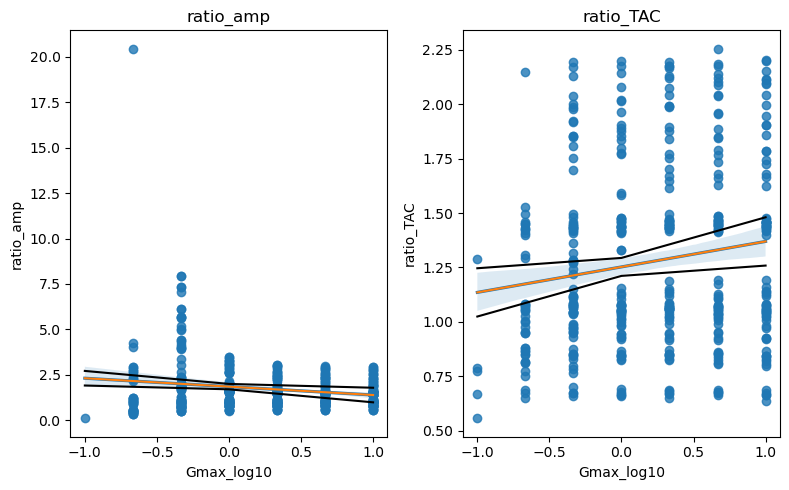

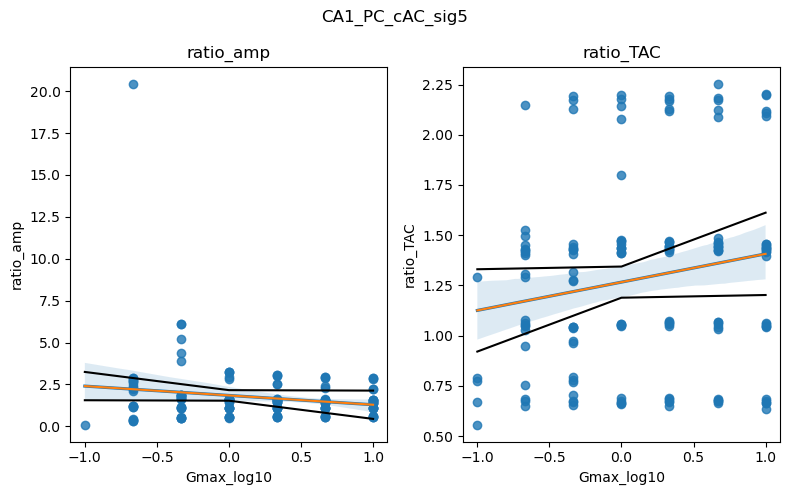

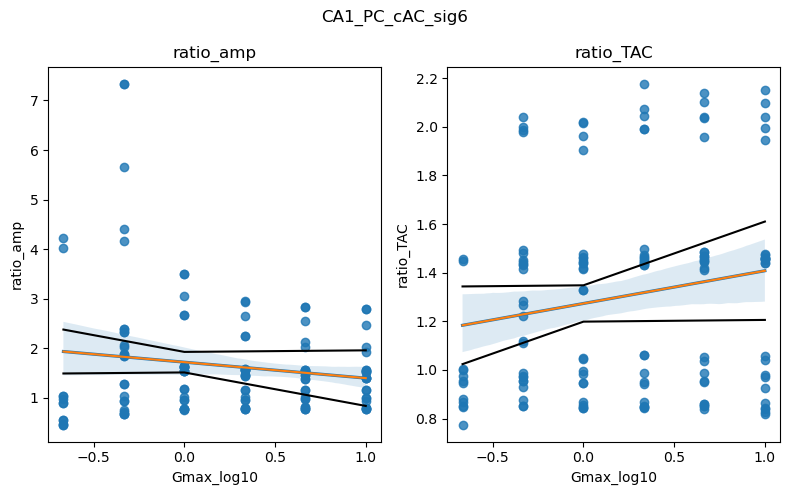

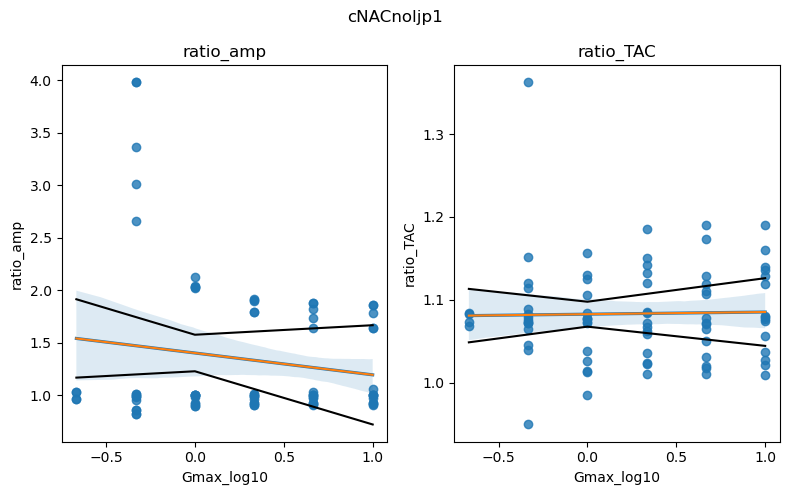

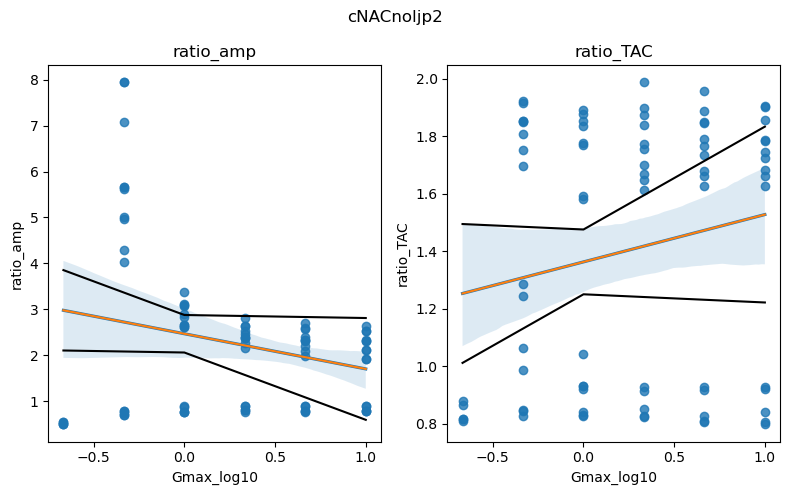

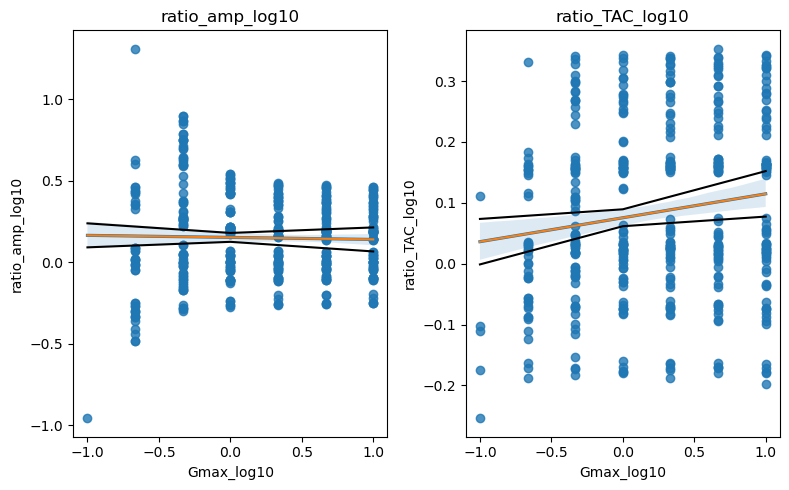

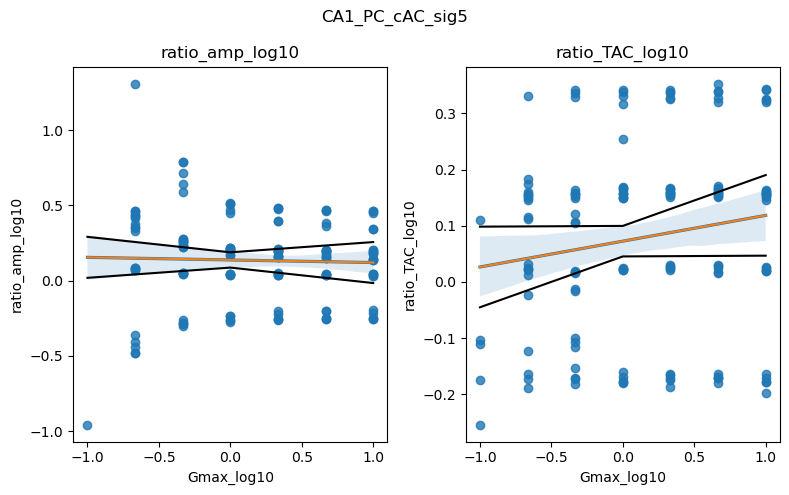

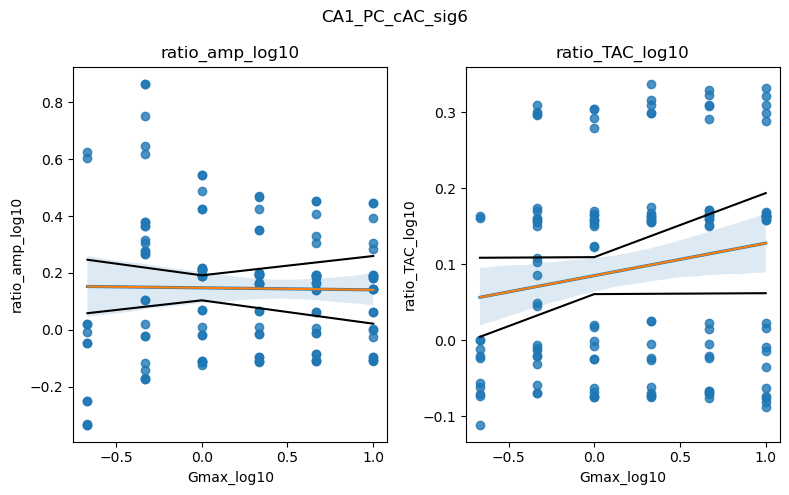

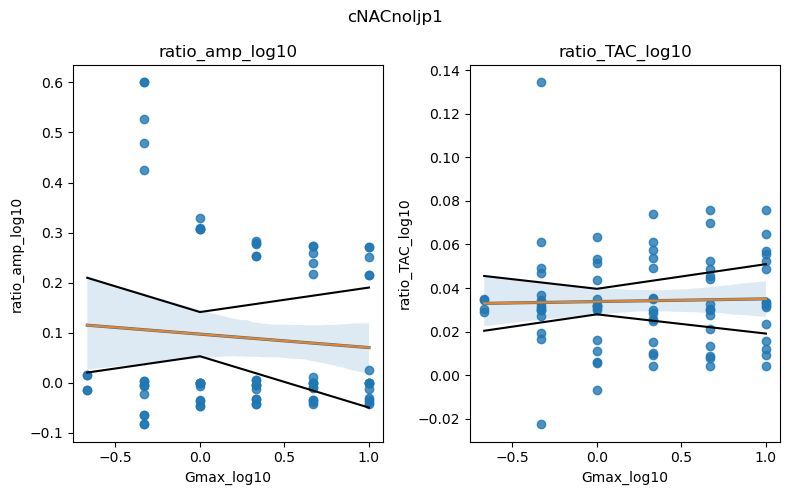

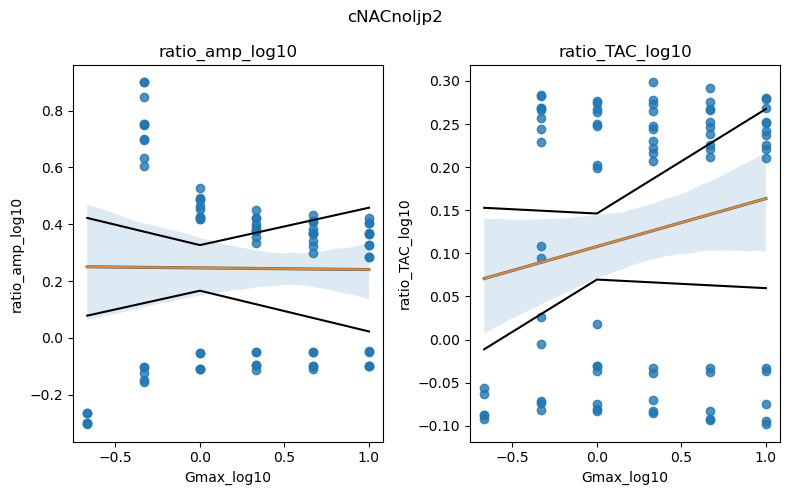

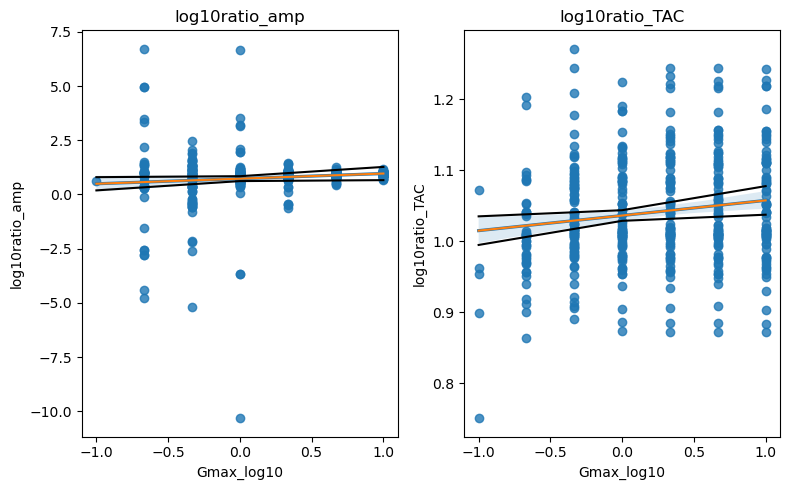

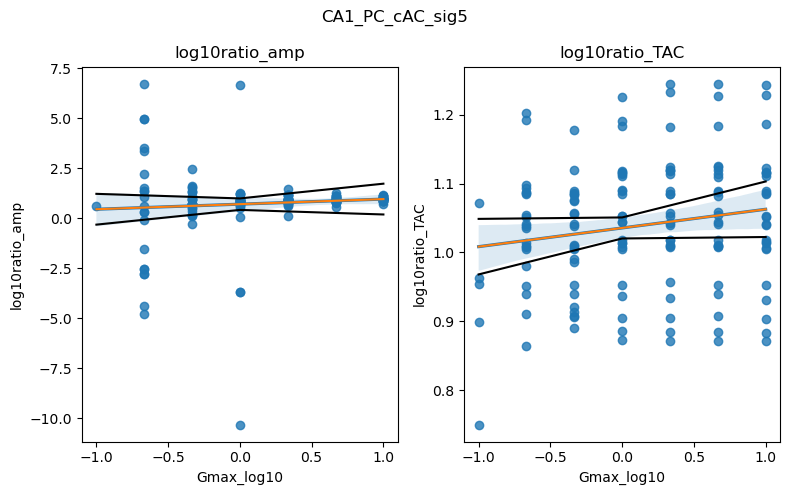

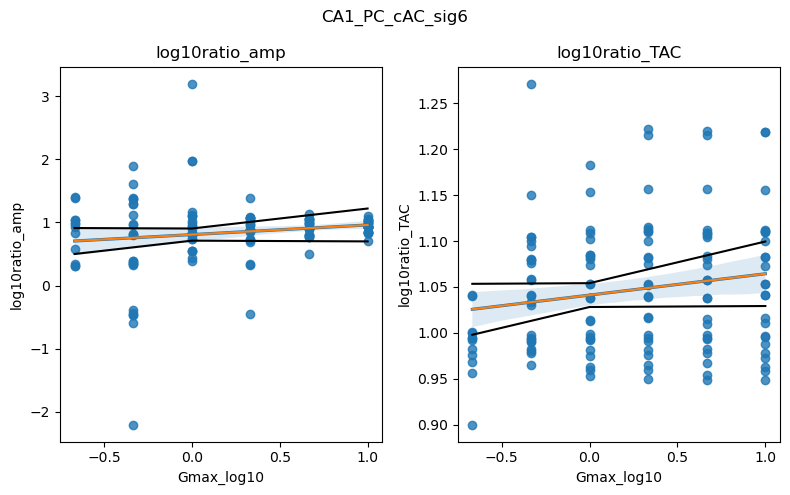

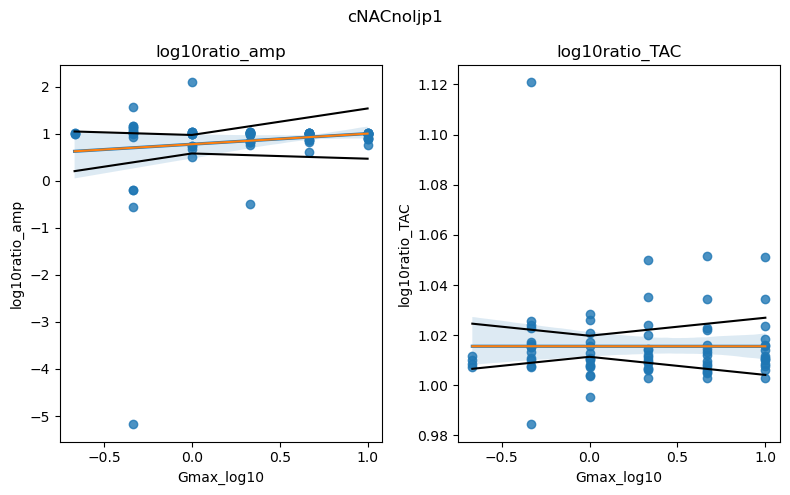

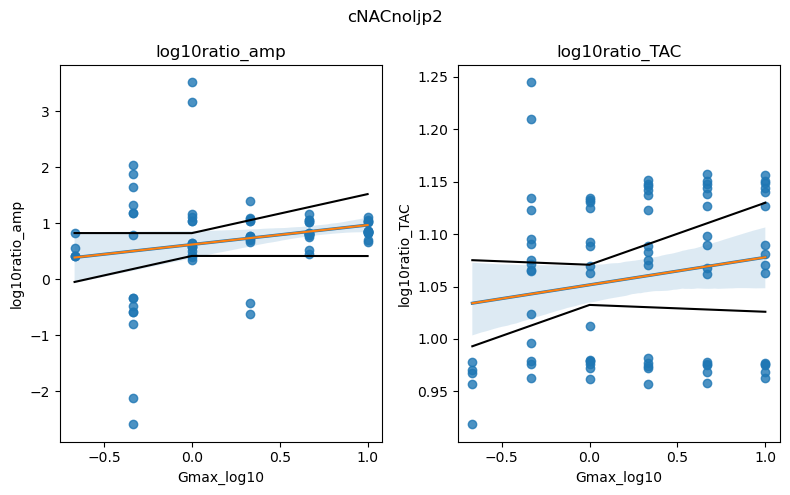

In [31]:
ress_relSoma_dict = {'ratio_amp':{},'ratio_TAC':{},'ratio_amp_log10':{},'ratio_TAC_log10':{},'log10ratio_amp':{},'log10ratio_TAC':{}}
fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
filteronthreshold = True
ress = linearReg(rel_df,['ratio_amp','ratio_TAC'],axs,filteronthreshold,scatterplot=False)
ress_relSoma_dict['ratio_amp']['all'] = ress[0]
ress_relSoma_dict['ratio_TAC']['all'] = ress[1]
for cell in unique_values_columns_master['neurontemplate']:
    intm_df = rel_df[rel_df['neurontemplate']==cell]
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    print('\n\n',cell)
    ress = linearReg(intm_df,['ratio_amp','ratio_TAC'],axs,filteronthreshold,scatterplot=False)
    fig.suptitle(cell)
    ress_relSoma_dict['ratio_amp'][cell] = ress[0]
    ress_relSoma_dict['ratio_TAC'][cell] = ress[1]


fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
filteronthreshold = True
ress = linearReg(rel_df,['ratio_amp_log10','ratio_TAC_log10'],axs,filteronthreshold,scatterplot=False)
ress_relSoma_dict['ratio_amp_log10']['all'] = ress[0]
ress_relSoma_dict['ratio_TAC_log10']['all'] = ress[1]
for cell in unique_values_columns_master['neurontemplate']:
    intm_df = rel_df[rel_df['neurontemplate']==cell]
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    print('\n\n',cell)
    ress = linearReg(intm_df,['ratio_amp_log10','ratio_TAC_log10'],axs,filteronthreshold,scatterplot=False)
    fig.suptitle(cell)
    ress_relSoma_dict['ratio_amp_log10'][cell] = ress[0]
    ress_relSoma_dict['ratio_TAC_log10'][cell] = ress[1]


fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
filteronthreshold = True
ress = linearReg(rel_df,['log10ratio_amp','log10ratio_TAC'],axs,filteronthreshold,scatterplot=False)
ress_relSoma_dict['log10ratio_amp']['all'] = ress[0]
ress_relSoma_dict['log10ratio_TAC']['all'] = ress[1]
for cell in unique_values_columns_master['neurontemplate']:
    intm_df = rel_df[rel_df['neurontemplate']==cell]
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    print('\n\n',cell)
    ress = linearReg(intm_df,['log10ratio_amp','log10ratio_TAC'],axs,filteronthreshold,scatterplot=False)
    fig.suptitle(cell)
    ress_relSoma_dict['log10ratio_amp'][cell] = ress[0]
    ress_relSoma_dict['log10ratio_TAC'][cell] = ress[1]

## ratio pyramidal sig6 vs pyramidal sig5

pyramidal sig6 more difficult to excite (+- double intensity) than sig 5
- highest ratio for basal dend location
- factor 4 -> 5 (short vs large pd) at low Gmax -> translate to factor 1.5 in TAC
- Higher Gmax ratio drops to 2

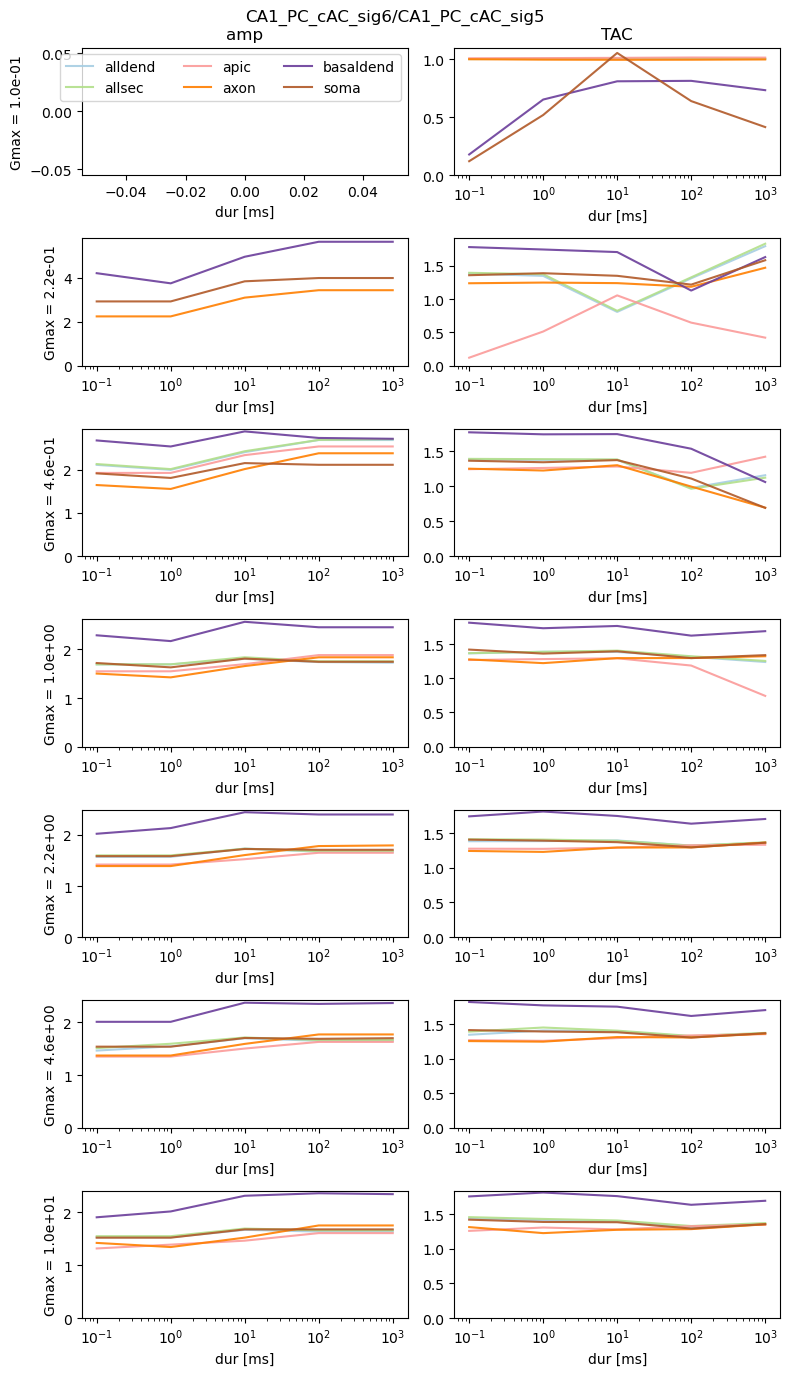

In [13]:
variables = unique_values_columns_master['neurontemplate'][:2]
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-3]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))


cell_diff_dict = {}
uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
cell_diff_dict['pyr'] = {key:{'amp':[],'TAC':[],'Gmax':[],'durs':[]} for key in uOpsinLocations}
for i,datalabel in enumerate(['amp','TAC']):
    uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
    for oL in uOpsinLocations:
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = master_df[master_df['Gmax']==uG]

            clr = colorpairs[oL]
            plot_df = intm_df[intm_df['opsinlocations']==oL]
            xdata = plot_df['dur'][plot_df['neurontemplate']==variables[1]]
            ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[1]]
            ref_ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[0]]
            if len(ydata)==len(ref_ydata):
                ydata = np.array(ydata)/np.array(ref_ydata)
                ax.plot(xdata,ydata,color=clr,alpha=0.9,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                #ax.set_yscale('log')
                if oL==uOpsinLocations[-1]:
                    ax.set_ylim([0,ax.get_ylim()[1]])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{variables[1]}/{variables[0]}')
    print()

## statistical violin plots of data above

In [133]:
# Relative to soma SDC
df1 = master_df[master_df['opsinlocations']=='soma']
df2 = master_df[master_df['opsinlocations']!='soma']
df1 = df1.set_index(['neurontemplate','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['neurontemplate','dur','Gmax','opsinlocations'])[['amp','sR','TAC','gchr2']]
rel_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    rel_df['ratio_'+key] = rel_df[key+'_1']/rel_df[key+'_0']
rel_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = rel_df.groupby('neurontemplate')[columns]
overall_rel_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
overall_rel_df[[f'ratio_{x}{y}' for x in ['amp','TAC','gchr2'] for y in ['_mean','_std']]]

ratio_amp_mean  ratio_amp_std  ratio_TAC_mean  ratio_TAC_std  \
neurontemplate                                                                  
CA1_PC_cAC_sig5        1.746437       1.859974        1.200787       0.507117   
CA1_PC_cAC_sig6        1.642813       1.121579        1.229820       0.384073   
cNACnoljp1             1.344671       0.683038        1.034806       0.134119   
cNACnoljp2             2.262077       1.662046        1.241788       0.452759   

                 ratio_gchr2_mean  ratio_gchr2_std  
neurontemplate                                      
CA1_PC_cAC_sig5         22.002899        11.689794  
CA1_PC_cAC_sig6         15.560348        10.771100  
cNACnoljp1              38.202636        35.559115  
cNACnoljp2              33.426926        15.564962

In [ ]:
df1 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][0]]
df2 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][1]]
df1 = df1.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
pyr_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_0', '_1'))
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    pyr_df['ratio_'+key] = pyr_df[key+'_1']/pyr_df[key+'_0']
pyr_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = pyr_df.groupby('opsinlocations')[columns]
overall_pyr_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
overall_pyr_df



ratio_amp_mean  ratio_TAC_mean  ratio_gchr2_mean  \
opsinlocations                                                     
alldend               1.788940        1.316510          1.451094   
allsec                1.807495        1.327614          1.451646   
apic                  1.600870        1.179573          1.273732   
axon                  1.876362        1.151964          1.497693   
basaldend             2.558635        1.588870          1.667671   
soma                  2.031525        1.155980          2.007117   

                ratio_amp_std  ratio_TAC_std  ratio_gchr2_std  
opsinlocations                                                 
alldend              0.609824       0.162639         1.087553  
allsec               0.607509       0.168911         0.226247  
apic                 0.307034       0.261721         1.018476  
axon                 0.570488       0.161644         0.333351  
basaldend            0.883518       0.357410         0.387169  
soma                 0.727843       0.295897         0.558765

In [ ]:
grouped = pyr_df.groupby(['opsinlocations','dur'])[columns]
dur_pyr_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
dur_pyr_df

ratio_amp_mean  ratio_TAC_mean  ratio_gchr2_mean  \
opsinlocations dur                                                        
alldend        0.1           1.984720        1.346484          2.065650   
               1.0           1.606383        1.357321          1.173039   
               10.0          1.770386        1.294766          1.255126   
               100.0         1.779414        1.249808          1.366384   
               1000.0        1.779321        1.334171          1.395271   
allsec         0.1           2.007213        1.366135          1.572668   
               1.0           1.619954        1.367630          1.478241   
               10.0          1.789073        1.304950          1.438371   
               100.0         1.797676        1.257820          1.354514   
               1000.0        1.798595        1.341536          1.414434   
apic           0.1           1.438896        1.128674          1.816068   
               1.0           1.438269        1.161599          1.094026   
               10.0          1.609958        1.241910          1.022019   
               100.0         1.757944        1.199611          1.253386   
               1000.0        1.759285        1.166074          1.183162   
axon           0.1           1.594898        1.157835          1.449703   
               1.0           1.553811        1.139151          1.668012   
               10.0          1.913675        1.170712          1.461199   
               100.0         2.158662        1.135445          1.442848   
               1000.0        2.160766        1.156680          1.466703   
basaldend      0.1           2.302982        1.613778          1.699190   
               1.0           2.274260        1.657433          1.763064   
               10.0          2.685205        1.656653          1.745802   
               100.0         2.766353        1.488515          1.554088   
               1000.0        2.764374        1.527972          1.576210   
soma           0.1           1.866366        1.149291          2.035408   
               1.0           1.833915        1.177544          2.043119   
               10.0          2.150463        1.229751          2.127182   
               100.0         2.152442        1.113917          1.938096   
               1000.0        2.154438        1.109397          1.891779   

                       ratio_amp_std  ratio_TAC_std  ratio_gchr2_std  
opsinlocations dur                                                    
alldend        0.1          1.205545       0.124057         2.279221  
               1.0          0.171906       0.127442         0.410259  
               10.0         0.267525       0.210084         0.663045  
               100.0        0.371101       0.136754         0.170373  
               1000.0       0.370528       0.202189         0.219225  
allsec         0.1          1.199172       0.130908         0.248556  
               1.0          0.174699       0.130790         0.225826  
               10.0         0.268623       0.210402         0.229722  
               100.0        0.364222       0.144448         0.166601  
               1000.0       0.371624       0.215246         0.236867  
apic           0.1          0.214527       0.364300         2.134516  
               1.0          0.217869       0.242534         0.278341  
               10.0         0.306981       0.110576         0.617955  
               100.0        0.332342       0.220126         0.257089  
               1000.0       0.331465       0.335423         0.351042  
axon           0.1          0.330051       0.137551         0.228012  
               1.0          0.342648       0.121697         0.555294  
               10.0         0.601623       0.150500         0.209684  
               100.0        0.665937       0.148958         0.227325  
               1000.0       0.664532       0.250495         0.329145  
basaldend      0.1          0.759414       0.505141         

Text(0.5, 0.98, 'opsin in section x/opsin in soma')

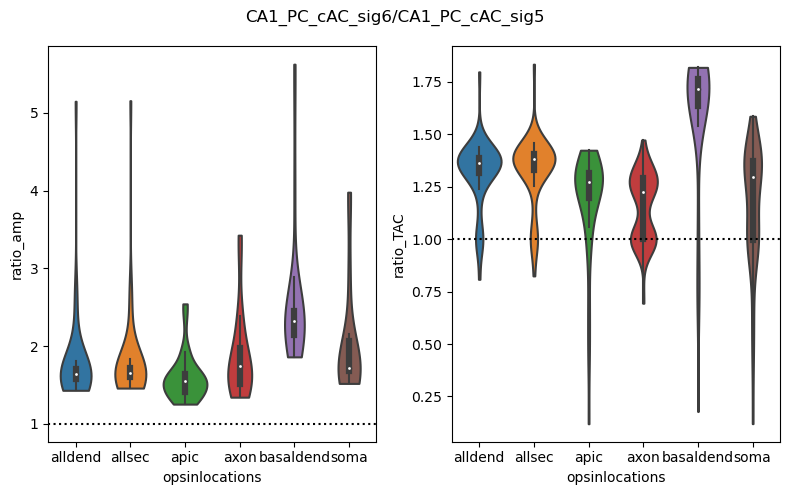

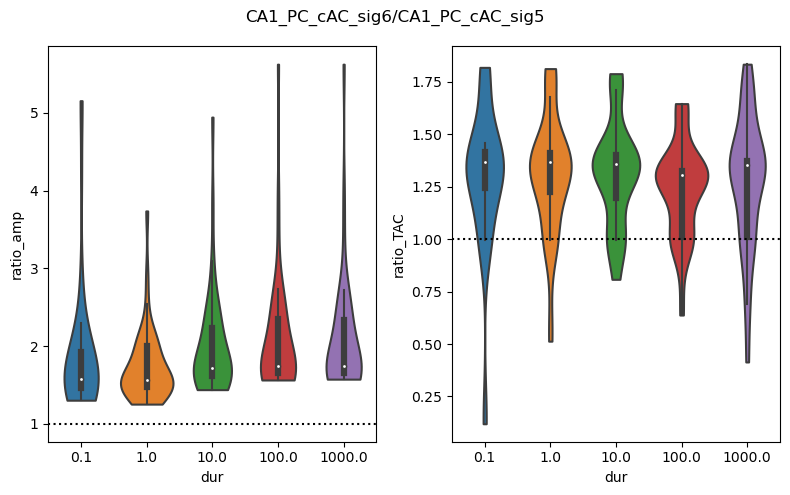

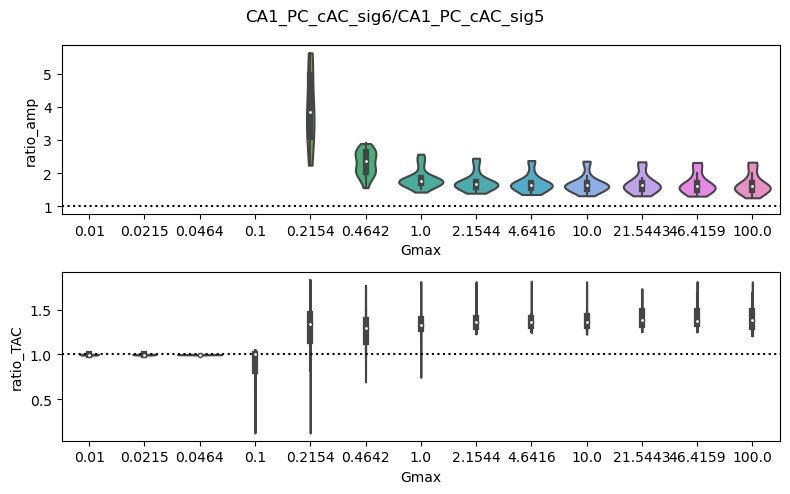

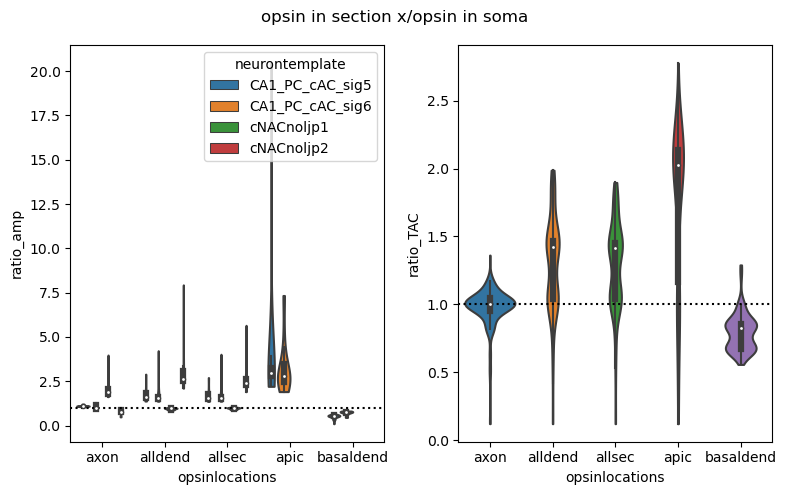

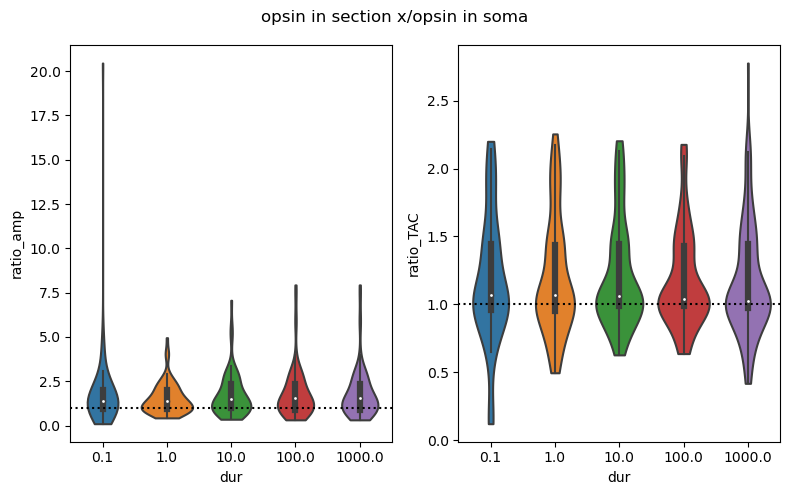

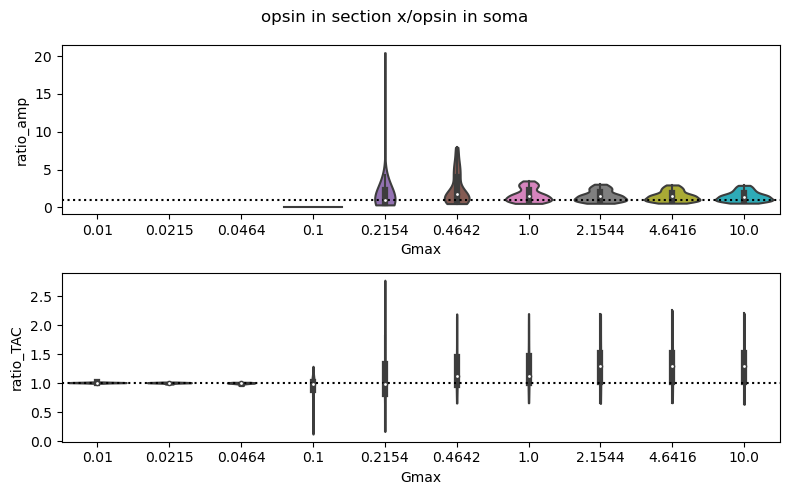

In [ ]:

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))

sns.violinplot(data=pyr_df,y='ratio_amp',x='opsinlocations',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='opsinlocations',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=pyr_df,y='ratio_amp',x='dur',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='dur',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=pyr_df,y='ratio_amp',x='Gmax',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='Gmax',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='opsinlocations',hue='neurontemplate',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='opsinlocations',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='dur',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='dur',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='Gmax',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='Gmax',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

ratio_amp_mean  ratio_TAC_mean  ratio_gchr2_mean  \
opsinlocations                                                     
alldend               2.844653        1.397635          1.931265   
allsec                2.376125        1.333592          1.663435   
axon                  0.357354        0.944507          0.164470   
soma                  0.854519        0.937464          0.525020   

                ratio_amp_std  ratio_TAC_std  ratio_gchr2_std  
opsinlocations                                                 
alldend              1.467010       0.372179         0.550224  
allsec               0.907548       0.337094         0.527679  
axon                 0.106021       0.523376         0.075300  
soma                 0.116036       0.048687         0.150461

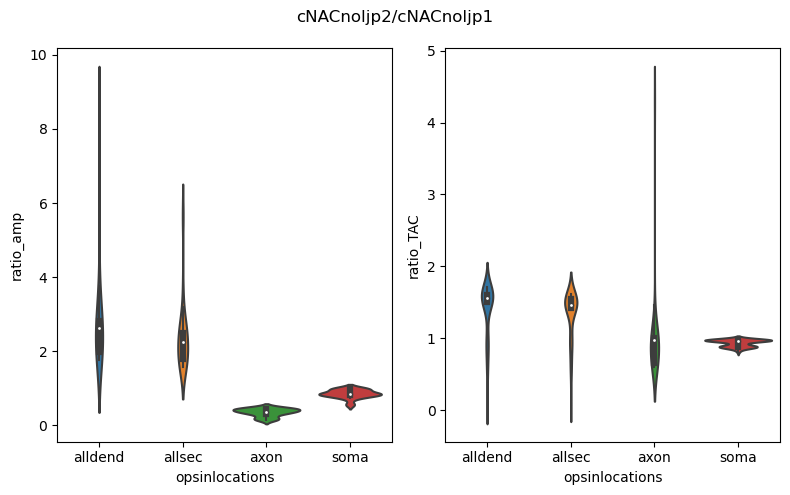

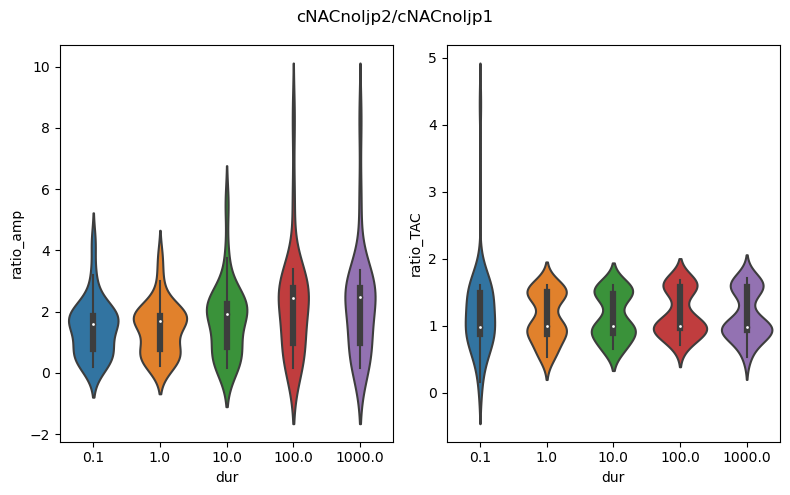

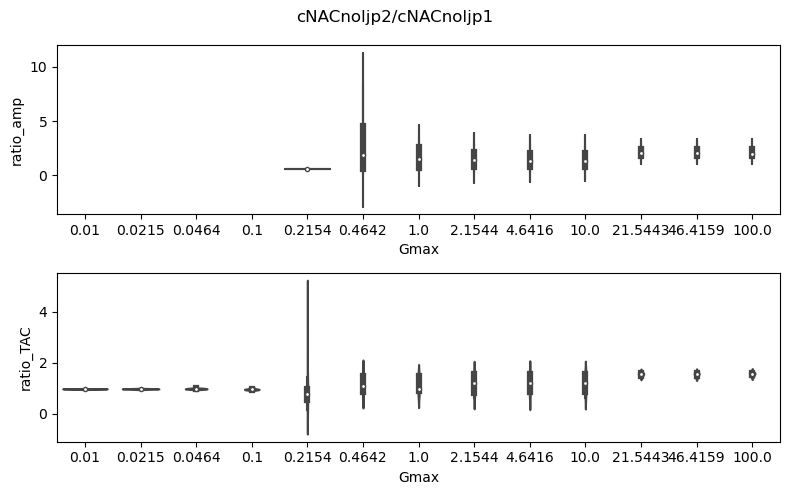

In [ ]:
df1 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][2]]
df2 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][3]]
df1 = df1.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
int_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_0', '_1'))
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    int_df['ratio_'+key] = int_df[key+'_1']/int_df[key+'_0']
int_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = int_df.groupby('opsinlocations')[columns]
overall_int_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='opsinlocations',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='opsinlocations',ax=axs[1])
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='dur',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='dur',ax=axs[1])
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='Gmax',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='Gmax',ax=axs[1])
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

overall_int_df

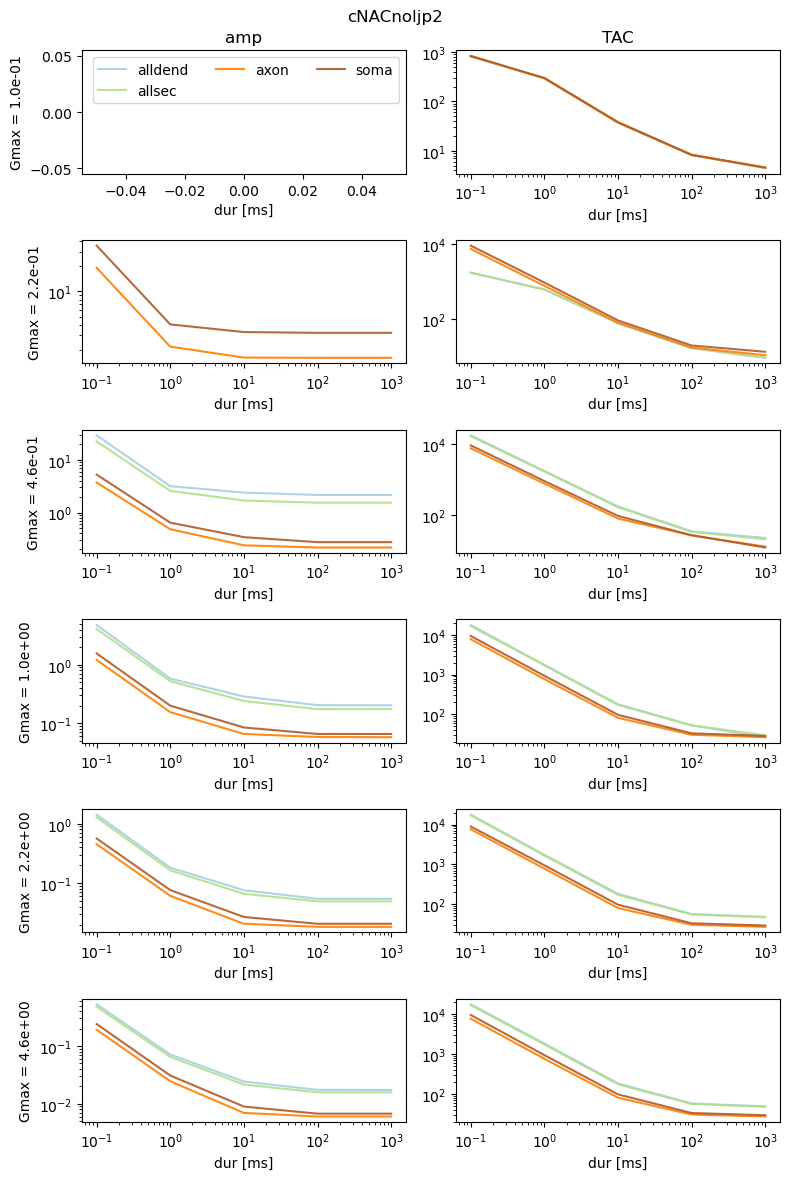

In [ ]:
reference = ''
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle in zip(unique_values_columns_master['neurontemplate'][3:],linestyle_str):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]
    uGmax = np.sort(fig_df['Gmax'].unique())[3:-4]
    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                ax.plot(xdata,ydata,color=clr,alpha=0.9,linestyle=linestyle,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

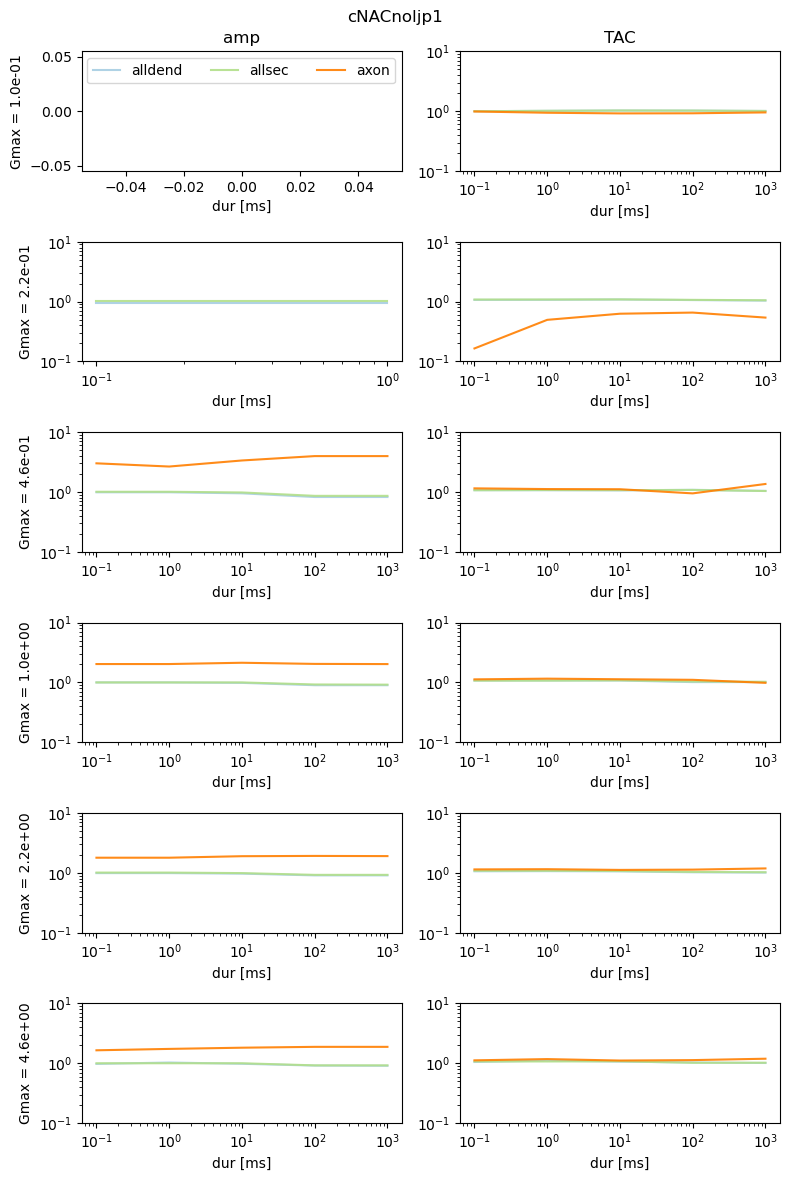

In [ ]:
reference = 'soma'
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle,alpha in zip(unique_values_columns_master['neurontemplate'][2:3],linestyle_str,[0.9,0.7]):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]


    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                if len(ydata)==len(ref_ydata):
                    ydata = np.array(ydata)/np.array(ref_ydata)
                    ax.plot(xdata,ydata,color=clr,alpha=alpha,linestyle=linestyle,label=oL)
                    if sum(~ np.isnan(ydata))>0:
                        logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_ylim([0.1,10])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

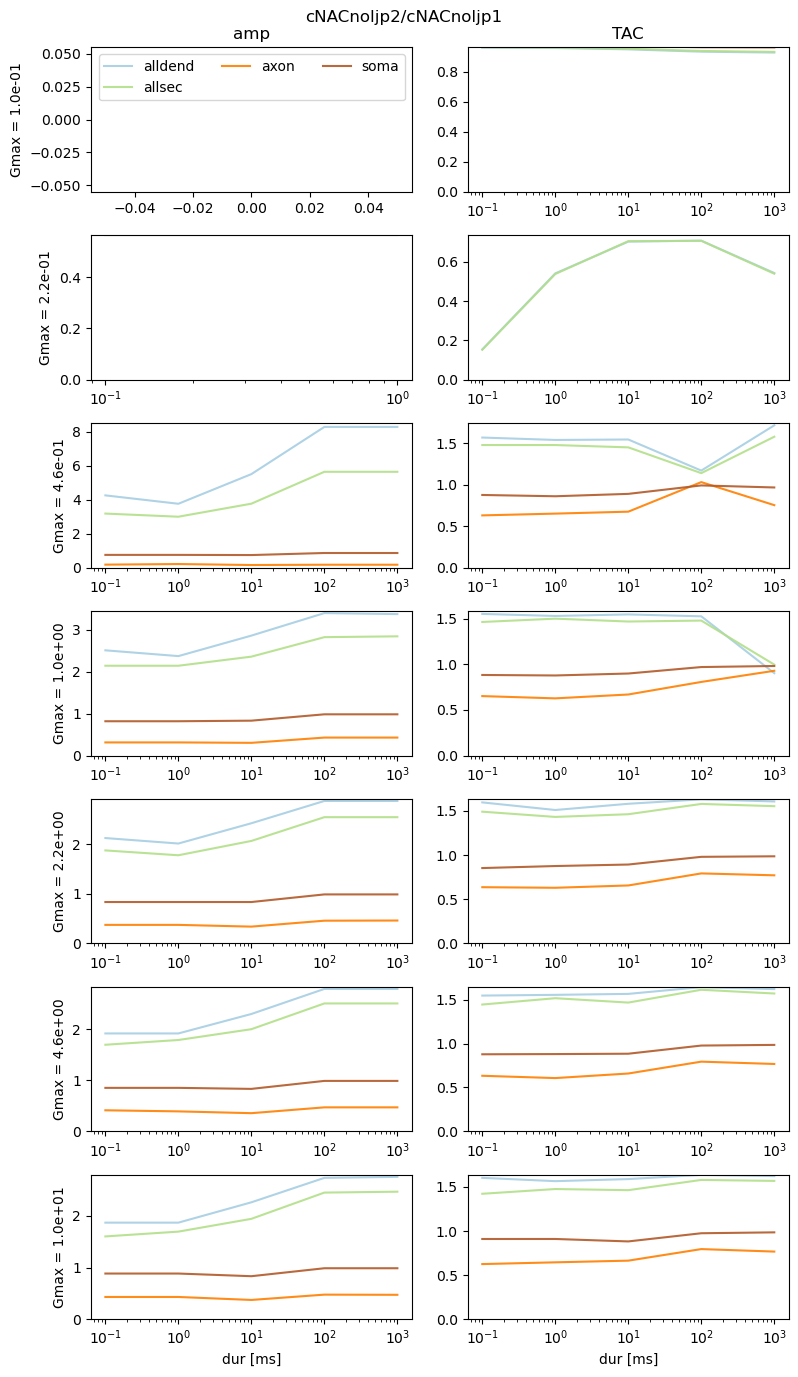

In [ ]:
variables = unique_values_columns_master['neurontemplate'][2:4]
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-3]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))


cell_diff_dict = {}
uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
cell_diff_dict['pyr'] = {key:{'amp':[],'TAC':[],'Gmax':[],'durs':[]} for key in uOpsinLocations}
for i,datalabel in enumerate(['amp','TAC']):
    uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
    for oL in uOpsinLocations:
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = master_df[master_df['Gmax']==uG]

            clr = colorpairs[oL]
            plot_df = intm_df[intm_df['opsinlocations']==oL]
            xdata = plot_df['dur'][plot_df['neurontemplate']==variables[1]]
            ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[1]]
            ref_ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[0]]
            if len(ydata)==len(ref_ydata):
                ydata = np.array(ydata)/np.array(ref_ydata)
                ax.plot(xdata,ydata,color=clr,alpha=0.9,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                #ax.set_yscale('log')
                ax.set_ylim([0,ax.get_ylim()[1]])
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)
        ax.set_xlabel('dur [ms]')


    fig.suptitle(f'{variables[1]}/{variables[0]}')
    print()

In [27]:


def amp_log10func(x,a,b,c,d):
    return a*(x-d)+c

popt, pcov = optimize.curve_fit(amp_log10func, xdata, ydata,p0=[1,1,0],bounds=([-np.inf,0,-np.inf],+np.inf))
print(popt)
print(pcov)

C:\Users\rschoete\AppData\Local\Temp\ipykernel_18008\3370439728.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  return a*x**(-b)+c


ValueError: Residuals are not finite in the initial point.